# Cohort-Based CLV Forecasting with PyMC-Marketing

This notebook implements a **cohort-based approach** to Customer Lifetime Value (CLV)
forecasting using PyMC-Marketing's BG/NBD and Gamma-Gamma models.

## Approach

Instead of fitting a single model to all ~1.3M customers, we fit separate models
per monthly cohort. This addresses two key challenges:

1. **Dataset Size**: Each cohort has a manageable number of customers
2. **Seasonality**: Different cohorts capture seasonal acquisition patterns implicitly

## Models

- **BG/NBD (Beta-Geometric/NBD)**: Models customer purchase frequency and dropout
- **Gamma-Gamma**: Models monetary value of transactions

## Data Source

[H&M Personalized Fashion Recommendations](https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations/data)

---
## 1. Setup and Configuration

**Global Parameters:**

- `MAX_COHORT_SIZE`: Controls subsampling for faster testing/debugging.
  - Set to an integer (e.g., 10000) to subsample large cohorts
  - Set to `None` for production runs with full data

**Usage:**
```python
MAX_COHORT_SIZE = 10000  # Fast testing (~10 min total)
MAX_COHORT_SIZE = None   # Full dataset (production run)
```

In [ ]:
from __future__ import annotations

import time
from datetime import date
from typing import Any

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import xarray as xr
from pymc_extras.prior import Prior
from pymc_marketing.clv import BetaGeoModel, GammaGammaModel

# Plotting configuration
az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# =============================================================================
# GLOBAL CONFIGURATION PARAMETERS
# =============================================================================

# MAX_COHORT_SIZE: Maximum number of customers per cohort for model fitting.
# - Set to an integer (e.g., 10000) for faster testing/debugging
# - Set to None to use all customers (production run)
MAX_COHORT_SIZE: int | None = None  # Change to None for full dataset

# Random seed for reproducibility
SEED: int = sum(map(ord, "hm_clv_cohort_based"))
RNG: np.random.Generator = np.random.default_rng(seed=SEED)

# Model configurations with informative priors for numerical stability
# =============================================================================
# BG/NBD Model Configuration with Progressive Prior Tightening
# =============================================================================
#
# PROBLEM: MAP estimation for BG/NBD can produce NaN parameters for cohorts with
# extreme data characteristics (e.g., very high repeat rates, unusual recency/T ratios).
# The optimizer pushes parameters toward extreme values causing numerical instability.
#
# SOLUTION: Progressive fallback strategy with increasingly tight priors:
#
# 1. DEFAULT PRIORS (sigma=10): Wide priors that work for most cohorts
#    - Allows flexibility for diverse customer behaviors
#    - May fail for cohorts with extreme statistics
#
# 2. TIGHT PRIORS (sigma=2-5): First fallback for problematic cohorts
#    - Constrains parameter space to avoid extreme values
#    - Works for high-frequency cohorts (e.g., mean frequency > 20)
#
# 3. VERY TIGHT PRIORS (sigma=1-2): Second fallback for very problematic cohorts
#    - Strongly constrains parameters near typical values
#    - Works for cohorts with low recency/T ratios (appearing "dormant")
#
# The fitting function tries each configuration in order, with multiple random
# seeds per configuration, until a valid (non-NaN) fit is obtained.
# =============================================================================

BG_NBD_MODEL_CONFIG: dict[str, Prior] = {
    "a": Prior("HalfNormal", sigma=10),
    "b": Prior("HalfNormal", sigma=10),
    "alpha": Prior("HalfNormal", sigma=10),
    "r": Prior("HalfNormal", sigma=10),
}

# Tighter priors for cohorts with extreme data (high repeat rates, high frequency)
# These constrain parameter space to avoid numerical instability in MAP
BG_NBD_MODEL_CONFIG_TIGHT: dict[str, Prior] = {
    "a": Prior("HalfNormal", sigma=2),
    "b": Prior("HalfNormal", sigma=2),
    "alpha": Prior("HalfNormal", sigma=5),
    "r": Prior("HalfNormal", sigma=2),
}

# Very tight priors for extremely problematic cohorts (low recency/T ratio)
BG_NBD_MODEL_CONFIG_VERY_TIGHT: dict[str, Prior] = {
    "a": Prior("HalfNormal", sigma=1),
    "b": Prior("HalfNormal", sigma=1),
    "alpha": Prior("HalfNormal", sigma=2),
    "r": Prior("HalfNormal", sigma=1),
}

GAMMA_GAMMA_MODEL_CONFIG: dict[str, Prior] = {
    "p": Prior("HalfNormal", sigma=10),
    "q": Prior("HalfNormal", sigma=10),
    "v": Prior("HalfNormal", sigma=100),
}

print(f"MAX_COHORT_SIZE: {MAX_COHORT_SIZE}")
print(f"SEED: {SEED}")

MAX_COHORT_SIZE: None
SEED: 1989


---
## 2. Data Loading and Exploration

We load the H&M transactions dataset containing:
- `t_dat`: Transaction date
- `customer_id`: Unique customer identifier
- `price`: Transaction amount

The dataset spans from September 2018 to September 2020.

In [ ]:
# Load raw transaction data
# Source: https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations/data
raw_df = pl.read_csv(
    "../../data/transactions_train.csv",
    columns=["t_dat", "customer_id", "price"],
    try_parse_dates=True,
)

print(f"Raw data shape: {raw_df.shape}")
raw_df.head()

Raw data shape: (31788324, 3)


t_dat,customer_id,price
date,str,f64
2018-09-20,"""000058a12d5b43e67d225668fa1f8d…",0.050831
2018-09-20,"""000058a12d5b43e67d225668fa1f8d…",0.030492
2018-09-20,"""00007d2de826758b65a93dd24ce629…",0.015237
2018-09-20,"""00007d2de826758b65a93dd24ce629…",0.016932
2018-09-20,"""00007d2de826758b65a93dd24ce629…",0.016932


In [ ]:
# Basic statistics
print(f"Date range: {raw_df['t_dat'].min()} to {raw_df['t_dat'].max()}")
print(f"Number of unique customers: {raw_df['customer_id'].n_unique():,}")
print(f"Number of transactions: {raw_df.height:,}")
print(f"Total revenue: {raw_df['price'].sum():,.2f}")

Date range: 2018-09-20 to 2020-09-22
Number of unique customers: 1,362,281
Number of transactions: 31,788,324
Total revenue: 884,645.97


---
## 3. Train/Test Split Definition

We use a temporal split:
- **Training**: All transactions up to June 1, 2020
- **Test**: July, August, September 2020 (last ~3.5 months)

This allows us to evaluate the model's ability to forecast future revenue.

In [ ]:
# Define train/test split dates
PERIOD_TRAIN_TEST_SPLIT = date(2020, 6, 1)
TEST_PERIOD_END = date(2020, 9, 22)  # End of available data

print(f"Training period: up to {PERIOD_TRAIN_TEST_SPLIT}")
print(f"Test period: {PERIOD_TRAIN_TEST_SPLIT} to {TEST_PERIOD_END}")

Training period: up to 2020-06-01
Test period: 2020-06-01 to 2020-09-22


In [ ]:
# Filter data for complete months (consistent with hm-transactions.ipynb)
# We use data starting from 2018-10-01 for proper cohort assignment
# October cohort is excluded later via COHORT_START_DATE filter
DATA_START_DATE = date(2018, 10, 1)

filtered_df = raw_df.filter(
    (pl.col("t_dat") >= DATA_START_DATE) & (pl.col("t_dat") < date(2020, 9, 1))
)

print(f"Filtered data shape: {filtered_df.shape}")
date_min = filtered_df["t_dat"].min()
date_max = filtered_df["t_dat"].max()
print(f"Date range after filtering: {date_min} to {date_max}")

Filtered data shape: (30395279, 3)
Date range after filtering: 2018-10-01 to 2020-08-31


---
## 4. Cohort Assignment

**Cohort Definition**: A customer's cohort is determined by their **first purchase month**.

For example:
- Customer who first purchased in November 2018 → Cohort 2018-11-01
- Customer who first purchased in March 2019 → Cohort 2019-03-01

This groups customers by when they were "acquired" by the business.

In [ ]:
# Assign cohorts based on first purchase month
customers_with_cohort_df = (
    filtered_df.with_columns(pl.col("t_dat").dt.truncate("1mo").alias("period"))
    .with_columns(pl.col("period").min().over("customer_id").alias("cohort"))
    .sort(["customer_id", "t_dat"])
)

print(
    f"Customers with cohort assigned: {customers_with_cohort_df.height:,} transactions"
)
customers_with_cohort_df.head(10)

Customers with cohort assigned: 30,395,279 transactions


t_dat,customer_id,price,period,cohort
date,str,f64,date,date
2018-12-27,"""00000dbacae5abe5e23885899a1fa4…",0.044051,2018-12-01,2018-12-01
2018-12-27,"""00000dbacae5abe5e23885899a1fa4…",0.035576,2018-12-01,2018-12-01
2018-12-27,"""00000dbacae5abe5e23885899a1fa4…",0.030492,2018-12-01,2018-12-01
2019-05-02,"""00000dbacae5abe5e23885899a1fa4…",0.010153,2019-05-01,2018-12-01
2019-05-25,"""00000dbacae5abe5e23885899a1fa4…",0.050831,2019-05-01,2018-12-01
2019-05-25,"""00000dbacae5abe5e23885899a1fa4…",0.050831,2019-05-01,2018-12-01
2019-07-25,"""00000dbacae5abe5e23885899a1fa4…",0.021169,2019-07-01,2018-12-01
2019-07-25,"""00000dbacae5abe5e23885899a1fa4…",0.012695,2019-07-01,2018-12-01
2019-09-18,"""00000dbacae5abe5e23885899a1fa4…",0.044051,2019-09-01,2018-12-01


In [ ]:
# Cohort size summary
cohort_sizes = (
    customers_with_cohort_df.group_by("cohort")
    .agg(
        pl.col("customer_id").n_unique().alias("n_customers"),
        pl.col("price").sum().alias("total_revenue"),
        pl.col("t_dat").count().alias("n_transactions"),
    )
    .sort("cohort")
)

print("Cohort Summary:")
print(cohort_sizes)

Cohort Summary:
shape: (23, 4)
┌────────────┬─────────────┬───────────────┬────────────────┐
│ cohort     ┆ n_customers ┆ total_revenue ┆ n_transactions │
│ ---        ┆ ---         ┆ ---           ┆ ---            │
│ date       ┆ u32         ┆ f64           ┆ u32            │
╞════════════╪═════════════╪═══════════════╪════════════════╡
│ 2018-10-01 ┆ 274220      ┆ 386508.668763 ┆ 13688543       │
│ 2018-11-01 ┆ 161658      ┆ 141617.878271 ┆ 5123821        │
│ 2018-12-01 ┆ 101305      ┆ 65172.938288  ┆ 2431291        │
│ 2019-01-01 ┆ 75394       ┆ 42878.373576  ┆ 1597982        │
│ 2019-02-01 ┆ 69683       ┆ 31409.551831  ┆ 1176994        │
│ …          ┆ …           ┆ …             ┆ …              │
│ 2020-04-01 ┆ 41109       ┆ 7151.783322   ┆ 265743         │
│ 2020-05-01 ┆ 30855       ┆ 5211.488051   ┆ 193598         │
│ 2020-06-01 ┆ 32028       ┆ 4425.901339   ┆ 179029         │
│ 2020-07-01 ┆ 23790       ┆ 2684.909186   ┆ 111655         │
│ 2020-08-01 ┆ 23179       ┆ 2336.56832

/var/folders/cm/3dzy9rdd5s3672z0s1brjkvh0000gn/T/ipykernel_19406/2133214319.py:16: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


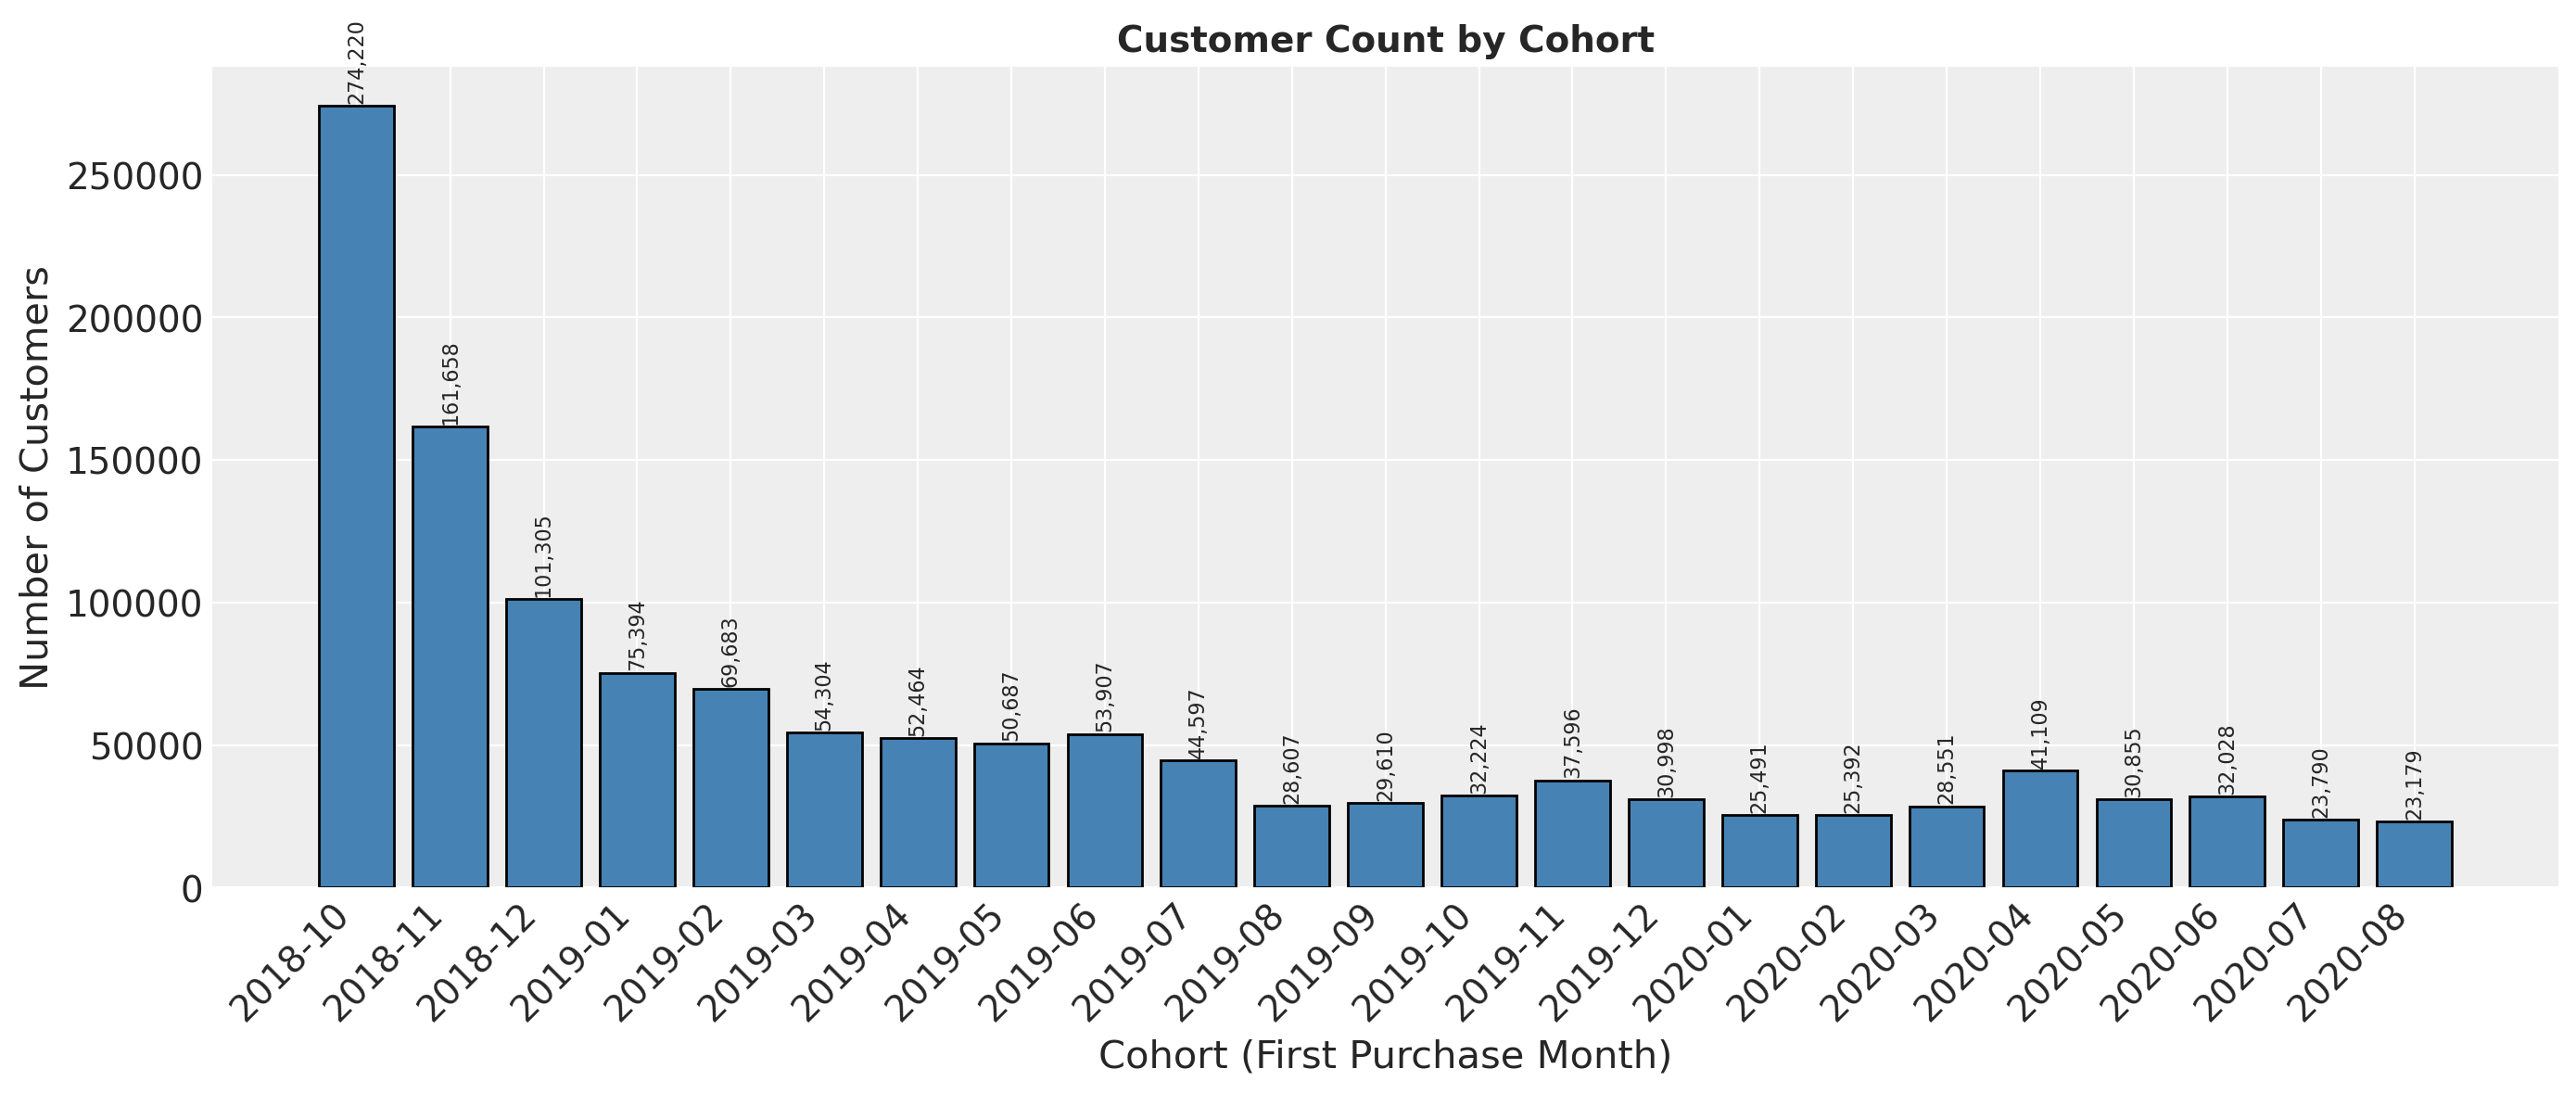

In [ ]:
# Visualize cohort sizes
fig, ax = plt.subplots(figsize=(14, 6))
cohort_dates = cohort_sizes["cohort"].to_list()
cohort_customers = cohort_sizes["n_customers"].to_list()

ax.bar(range(len(cohort_dates)), cohort_customers, color="steelblue", edgecolor="black")
ax.set_xticks(range(len(cohort_dates)))
ax.set_xticklabels([d.strftime("%Y-%m") for d in cohort_dates], rotation=45, ha="right")
ax.set_xlabel("Cohort (First Purchase Month)")
ax.set_ylabel("Number of Customers")
ax.set_title("Customer Count by Cohort", fontsize=14, fontweight="bold")

for i, n in enumerate(cohort_customers):
    ax.text(i, n + 1000, f"{n:,}", ha="center", va="bottom", fontsize=8, rotation=90)

plt.tight_layout()
plt.show()

---
## 5. Helper Functions (Data Processing)

These functions handle:
1. Computing RFM (Recency, Frequency, T, Monetary Value) metrics per customer
2. Adding cohort information
3. Summarizing cohort statistics for debugging
4. Subsampling cohorts if `MAX_COHORT_SIZE` is set

**RFM Definitions:**
- `frequency`: Number of *repeat* purchases (total purchases - 1)
- `recency`: Time between first and last purchase (in days)
- `T`: Time between first purchase and observation end (in days)
- `monetary_value`: Average spend per transaction (for repeat customers)

In [ ]:
def compute_rfm_by_cohort(
    transactions_df: pl.DataFrame,
    observation_end: date,
    time_unit: str = "D",
) -> pl.DataFrame:
    """
    Compute RFM metrics with cohort assignment for all customers.

    Parameters
    ----------
    transactions_df : pl.DataFrame
        Raw transactions with columns: customer_id, t_dat, price
    observation_end : date
        End of observation period for T calculation
    time_unit : str
        Time unit for recency and T: "D" (days) or "W" (weeks)

    Returns
    -------
    pl.DataFrame
        Columns: customer_id, frequency, recency, T, monetary_value, cohort
    """
    # Time unit divisor
    divisor = {"D": 1, "W": 7, "M": 30}.get(time_unit, 1)

    # Compute cohort (first purchase month) and RFM metrics
    return (
        transactions_df.with_columns(pl.col("t_dat").dt.truncate("1mo").alias("period"))
        .group_by("customer_id")
        .agg(
            pl.col("t_dat").min().alias("first_purchase"),
            pl.col("t_dat").max().alias("last_purchase"),
            pl.col("t_dat").count().alias("n_transactions"),
            pl.col("price").sum().alias("total_spend"),
            pl.col("period").min().alias("cohort"),
        )
        .with_columns(
            # frequency = number of repeat purchases (total - 1)
            (pl.col("n_transactions") - 1).alias("frequency"),
            # recency = time between first and last purchase
            (
                (pl.col("last_purchase") - pl.col("first_purchase"))
                .dt.total_days()
                .truediv(divisor)
            ).alias("recency"),
            # T = time between first purchase and observation end
            (
                (pl.lit(observation_end) - pl.col("first_purchase"))
                .dt.total_days()
                .truediv(divisor)
            ).alias("T"),
        )
        .with_columns(
            # monetary_value = average spend per transaction for repeat customers
            pl.when(pl.col("frequency") > 0)
            .then(pl.col("total_spend") / pl.col("n_transactions"))
            .otherwise(0.0)
            .alias("monetary_value")
        )
        .select(
            "customer_id",
            "frequency",
            "recency",
            "T",
            "monetary_value",
            "cohort",
        )
    )

In [ ]:
def get_cohort_summary(rfm_df: pl.DataFrame) -> pl.DataFrame:
    """
    Summarize cohort sizes and repeat customer counts for debugging.

    Parameters
    ----------
    rfm_df : pl.DataFrame
        RFM data with cohort column

    Returns
    -------
    pl.DataFrame
        Summary with columns: cohort, n_customers, n_repeat, pct_repeat
    """
    return (
        rfm_df.group_by("cohort")
        .agg(
            pl.col("customer_id").count().alias("n_customers"),
            (pl.col("frequency") > 0).sum().alias("n_repeat"),
            pl.col("frequency").mean().alias("avg_frequency"),
            pl.col("monetary_value")
            .filter(pl.col("frequency") > 0)
            .mean()
            .alias("avg_monetary"),
        )
        .with_columns(
            (pl.col("n_repeat") / pl.col("n_customers") * 100).alias("pct_repeat")
        )
        .sort("cohort")
    )

In [ ]:
def subsample_cohort_if_needed(
    rfm_data: pl.DataFrame,
    max_size: int | None,
    random_seed: int = SEED,
) -> tuple[pl.DataFrame, int, bool]:
    """
    Subsample cohort data if it exceeds max_size (without replacement).

    Sampling is done WITHOUT replacement to ensure each customer
    appears exactly once in the subsampled data.

    Parameters
    ----------
    rfm_data : pl.DataFrame
        RFM data for a single cohort
    max_size : int | None
        Maximum cohort size. If None, no subsampling.
    random_seed : int
        Random seed for reproducible subsampling

    Returns
    -------
    tuple[pl.DataFrame, int, bool]
        (subsampled_data, original_size, was_subsampled)
    """
    original_size = rfm_data.height

    if max_size is None:
        return rfm_data, original_size, False

    if rfm_data.height <= max_size:
        return rfm_data, original_size, False

    # Sample WITHOUT replacement to ensure unique customers
    subsampled = rfm_data.sample(n=max_size, seed=random_seed, with_replacement=False)
    return subsampled, original_size, True

In [ ]:
def validate_cohort_data(
    rfm_pd: pd.DataFrame,
    min_customers: int = 50,
    min_repeat_customers: int = 10,
) -> bool:
    """
    Validate cohort data meets minimum requirements for stable MAP fitting.

    Parameters
    ----------
    rfm_pd : pd.DataFrame
        RFM data for a single cohort (pandas DataFrame)
    min_customers : int
        Minimum number of customers required
    min_repeat_customers : int
        Minimum number of repeat customers (frequency > 0) required

    Returns
    -------
    bool
        True if data meets requirements, False otherwise
    """
    n_customers = len(rfm_pd)
    n_repeat = (rfm_pd["frequency"] > 0).sum()
    return n_customers >= min_customers and n_repeat >= min_repeat_customers

In [ ]:
def validate_fit_result(model) -> bool:
    """
    Check if model fit produced valid (non-NaN) parameter estimates.

    Parameters
    ----------
    model : BetaGeoModel or GammaGammaModel
        Fitted PyMC-Marketing model

    Returns
    -------
    bool
        True if all parameters are valid (no NaN/Inf), False otherwise
    """
    try:
        fit_result = model.fit_result
        for var_name in fit_result.data_vars:
            values = fit_result[var_name].to_numpy()
            if np.any(np.isnan(values)) or np.any(np.isinf(values)):
                return False
        return True
    except Exception:
        return False

---
## 6. Compute RFM Data

We compute RFM metrics for the training period (up to the train/test split date).

In [ ]:
# Filter training transactions
train_transactions_df = filtered_df.filter(pl.col("t_dat") <= PERIOD_TRAIN_TEST_SPLIT)

print(f"Training transactions: {train_transactions_df.height:,}")
print(f"Training customers: {train_transactions_df['customer_id'].n_unique():,}")

Training transactions: 26,085,162
Training customers: 1,249,683


In [ ]:
# Compute RFM metrics with cohort assignment
train_rfm_df_all = compute_rfm_by_cohort(
    transactions_df=train_transactions_df,
    observation_end=PERIOD_TRAIN_TEST_SPLIT,
    time_unit="D",  # Days for finer granularity
)

# Filter to only include cohorts from November 2018 onwards
# (consistent with hm-transactions.ipynb analysis)
COHORT_START_DATE = date(2018, 11, 1)
train_rfm_df = train_rfm_df_all.filter(pl.col("cohort") >= COHORT_START_DATE)

print(f"RFM data shape (all cohorts): {train_rfm_df_all.shape}")
print(f"RFM data shape (filtered cohorts >= {COHORT_START_DATE}): {train_rfm_df.shape}")
train_rfm_df.head(10)

RFM data shape (all cohorts): (1249683, 6)
RFM data shape (filtered cohorts >= 2018-11-01): (975463, 6)


customer_id,frequency,recency,T,monetary_value,cohort
str,u32,f64,f64,f64,date
"""6830528926d61d776139720553c692…",3,0.0,540.0,0.007403,2018-12-01
"""05f81598ec3f973be2fa6d7b9e24dc…",12,0.0,490.0,0.044442,2019-01-01
"""3631ea758bb9586366ed397c11c0d5…",3,25.0,74.0,0.021593,2020-03-01
"""96657d455798ccaa8f0d9539914c06…",4,0.0,171.0,0.025915,2019-12-01
"""e34207a278df641f88a2288b7a85b4…",3,0.0,22.0,0.008458,2020-05-01
"""b3a1e2e05ba7f2c711e0f619017e44…",0,0.0,553.0,0.0,2018-11-01
"""66fe8d3e5a0857bf491b0e50f3b492…",8,441.0,466.0,0.019795,2019-02-01
"""c4ee1e0ddc99ec96316a0c8a6ba06f…",10,490.0,564.0,0.024482,2018-11-01
"""d1d4cdf40064f2367e0da471c75f32…",6,0.0,460.0,0.017857,2019-02-01


In [ ]:
# Cohort summary for debugging
cohort_summary = get_cohort_summary(train_rfm_df)
print("Cohort Summary (Training Data):")
print(cohort_summary)

Cohort Summary (Training Data):
shape: (20, 6)
┌────────────┬─────────────┬──────────┬───────────────┬──────────────┬────────────┐
│ cohort     ┆ n_customers ┆ n_repeat ┆ avg_frequency ┆ avg_monetary ┆ pct_repeat │
│ ---        ┆ ---         ┆ ---      ┆ ---           ┆ ---          ┆ ---        │
│ date       ┆ u32         ┆ u32      ┆ f64           ┆ f64          ┆ f64        │
╞════════════╪═════════════╪══════════╪═══════════════╪══════════════╪════════════╡
│ 2018-11-01 ┆ 161658      ┆ 151238   ┆ 26.80674      ┆ 0.028088     ┆ 93.554294  │
│ 2018-12-01 ┆ 101305      ┆ 92743    ┆ 19.899808     ┆ 0.027369     ┆ 91.548295  │
│ 2019-01-01 ┆ 75394       ┆ 69808    ┆ 17.51077      ┆ 0.026802     ┆ 92.590922  │
│ 2019-02-01 ┆ 69683       ┆ 62805    ┆ 13.741831     ┆ 0.026735     ┆ 90.129587  │
│ 2019-03-01 ┆ 54304       ┆ 49763    ┆ 13.763701     ┆ 0.028443     ┆ 91.637817  │
│ …          ┆ …           ┆ …        ┆ …             ┆ …            ┆ …          │
│ 2020-02-01 ┆ 25392       ┆ 

In [ ]:
# Overall statistics
total_customers = train_rfm_df.height
n_repeat = train_rfm_df.filter(pl.col("frequency") > 0).height
n_single = train_rfm_df.filter(pl.col("frequency") == 0).height

print("\nOverall Statistics:")
print(f"  Total customers: {total_customers:,}")
print(f"  Repeat customers: {n_repeat:,} ({n_repeat / total_customers:.1%})")
print(f"  Single-purchase customers: {n_single:,} ({n_single / total_customers:.1%})")


Overall Statistics:
  Total customers: 975,463
  Repeat customers: 860,426 (88.2%)
  Single-purchase customers: 115,037 (11.8%)


---
## 7. Helper Functions (Model Fitting)

These functions fit the BG/NBD and Gamma-Gamma models for each cohort.

**Key design decisions:**

- Use MAP estimation by default for speed (MCMC available via `fit_method="mcmc"`)
- Gamma-Gamma requires repeat customers only (frequency > 0)
- Automatically subsamples if `MAX_COHORT_SIZE` is set
- Returns dict with models + metadata for later inspection

**Debugging tips:**

- Set `MAX_COHORT_SIZE=10000` for faster iteration during development
- Set `verbose=True` to see progress and subsampling status
- Check `result['n_repeat']` if Gamma-Gamma fails (need repeat customers)

In [ ]:
def fit_single_cohort(  # noqa: C901
    cohort_id: date,
    rfm_data: pl.DataFrame,
    fit_method: str = "map",
    sampler_kwargs: dict[str, Any] | None = None,
    max_cohort_size: int | None = MAX_COHORT_SIZE,
    min_customers: int = 50,
    min_repeat_customers: int = 10,
    model_config: dict[str, Prior] | None = None,
    max_retries: int = 10,
    *,
    verbose: bool = True,
) -> dict[str, Any]:
    """
    Fit BG/NBD and Gamma-Gamma models for a single cohort.

    Parameters
    ----------
    cohort_id : date
        The cohort identifier (first purchase month)
    rfm_data : pl.DataFrame
        RFM data for this cohort (Polars DataFrame)
    fit_method : str
        Fitting method: "map" for MAP estimation, "mcmc" for full MCMC
    sampler_kwargs : dict | None
        Additional kwargs for the sampler (used with fit_method="mcmc")
    max_cohort_size : int | None
        If not None, subsample cohort to this size before fitting
    min_customers : int
        Minimum number of customers required for fitting
    min_repeat_customers : int
        Minimum number of repeat customers required for Gamma-Gamma
    model_config : dict | None
        Model configuration with priors. If None, uses BG_NBD_MODEL_CONFIG
    max_retries : int
        Maximum number of fitting attempts with different random seeds
    verbose : bool
        If True, print progress messages

    Returns
    -------
    dict
        Keys: 'bgm', 'ggm', 'rfm_data', 'n_customers', 'n_repeat',
              'original_size', 'was_subsampled', 'fit_time', 'success'
    """
    start_time = time.time()

    # Subsample if needed
    rfm_subsampled, original_size, was_subsampled = subsample_cohort_if_needed(
        rfm_data, max_cohort_size
    )

    # Convert to pandas for PyMC-Marketing
    rfm_pd = rfm_subsampled.to_pandas()

    # Add small epsilon to monetary_value to avoid numerical issues with MAP
    eps = 1e-6
    rfm_pd["monetary_value"] = rfm_pd["monetary_value"].clip(lower=eps)

    n_customers = len(rfm_pd)
    n_repeat = int((rfm_pd["frequency"] > 0).sum())

    if verbose and was_subsampled:
        print(f"    Subsampled from {original_size:,} to {n_customers:,}")

    # Pre-fit data validation
    if not validate_cohort_data(rfm_pd, min_customers, min_repeat_customers):
        fit_time = time.time() - start_time
        return {
            "cohort_id": cohort_id,
            "bgm": None,
            "ggm": None,
            "rfm_data": rfm_subsampled,
            "rfm_pd": rfm_pd,
            "n_customers": n_customers,
            "n_repeat": n_repeat,
            "original_size": original_size,
            "was_subsampled": was_subsampled,
            "fit_time": fit_time,
            "success": False,
        }

    # Use default model config if not provided
    bgm_config = model_config if model_config is not None else BG_NBD_MODEL_CONFIG

    # Fit BG/NBD model with progressive prior fallback strategy
    # Try default priors first, then increasingly tight priors if needed
    bgm = None

    # Try with default priors first
    for attempt in range(max_retries):
        try:
            bgm = BetaGeoModel(data=rfm_pd, model_config=bgm_config)
            fit_kwargs = sampler_kwargs.copy() if sampler_kwargs else {}
            if fit_method == "map":
                fit_kwargs.setdefault("maxeval", 5000)
                fit_kwargs.setdefault("progressbar", False)
                # Use different seed for each attempt
                fit_kwargs["seed"] = (
                    SEED + attempt * 1000 + hash(str(cohort_id)) % 10000
                )
            bgm.fit(method=fit_method, **fit_kwargs)

            if validate_fit_result(bgm):
                break  # Success - exit retry loop
            bgm = None  # NaN detected, try again
        except Exception:
            bgm = None
            continue

    # Fallback 1: try with tighter priors if default failed
    if bgm is None and model_config is None:
        for attempt in range(max_retries):
            try:
                bgm = BetaGeoModel(data=rfm_pd, model_config=BG_NBD_MODEL_CONFIG_TIGHT)
                fit_kwargs = sampler_kwargs.copy() if sampler_kwargs else {}
                if fit_method == "map":
                    fit_kwargs.setdefault("maxeval", 5000)
                    fit_kwargs.setdefault("progressbar", False)
                    fit_kwargs["seed"] = (
                        SEED + attempt * 1000 + hash(str(cohort_id)) % 10000 + 100
                    )
                bgm.fit(method=fit_method, **fit_kwargs)

                if validate_fit_result(bgm):
                    break
                bgm = None
            except Exception:
                bgm = None
                continue

    # Fallback 2: try with very tight priors if tight priors also failed
    if bgm is None and model_config is None:
        for attempt in range(max_retries):
            try:
                bgm = BetaGeoModel(data=rfm_pd, model_config=BG_NBD_MODEL_CONFIG_VERY_TIGHT)
                fit_kwargs = sampler_kwargs.copy() if sampler_kwargs else {}
                if fit_method == "map":
                    fit_kwargs.setdefault("maxeval", 5000)
                    fit_kwargs.setdefault("progressbar", False)
                    fit_kwargs["seed"] = (
                        SEED + attempt * 1000 + hash(str(cohort_id)) % 10000 + 200
                    )
                bgm.fit(method=fit_method, **fit_kwargs)

                if validate_fit_result(bgm):
                    break
                bgm = None
            except Exception:
                bgm = None
                continue

    # If BG/NBD failed, return early
    if bgm is None:
        fit_time = time.time() - start_time
        return {
            "cohort_id": cohort_id,
            "bgm": None,
            "ggm": None,
            "rfm_data": rfm_subsampled,
            "rfm_pd": rfm_pd,
            "n_customers": n_customers,
            "n_repeat": n_repeat,
            "original_size": original_size,
            "was_subsampled": was_subsampled,
            "fit_time": fit_time,
            "success": False,
        }

    # Fit Gamma-Gamma model (repeat customers only) with retry logic
    ggm = None
    repeat_data = rfm_pd[rfm_pd["frequency"] > 0].copy()
    if len(repeat_data) >= min_repeat_customers:
        repeat_data["monetary_value"] = repeat_data["monetary_value"].clip(lower=eps)
        for attempt in range(max_retries):
            try:
                ggm = GammaGammaModel(
                    data=repeat_data, model_config=GAMMA_GAMMA_MODEL_CONFIG
                )
                fit_kwargs = sampler_kwargs.copy() if sampler_kwargs else {}
                if fit_method == "map":
                    fit_kwargs.setdefault("maxeval", 5000)
                    fit_kwargs.setdefault("progressbar", False)
                    # Use different seed for each attempt (offset from BG/NBD)
                    fit_kwargs["seed"] = (
                        SEED + attempt * 1000 + hash(str(cohort_id)) % 10000 + 500
                    )
                ggm.fit(method=fit_method, **fit_kwargs)

                if validate_fit_result(ggm):
                    break  # Success - exit retry loop
                ggm = None  # NaN detected, try again
            except Exception:
                ggm = None
                continue

    fit_time = time.time() - start_time

    # Success requires both models to fit successfully
    success = bgm is not None and ggm is not None

    return {
        "cohort_id": cohort_id,
        "bgm": bgm,
        "ggm": ggm,
        "rfm_data": rfm_subsampled,
        "rfm_pd": rfm_pd,
        "n_customers": n_customers,
        "n_repeat": n_repeat,
        "original_size": original_size,
        "was_subsampled": was_subsampled,
        "fit_time": fit_time,
        "success": success,
    }

In [ ]:
def fit_all_cohorts(
    rfm_df: pl.DataFrame,
    fit_method: str = "map",
    sampler_kwargs: dict[str, Any] | None = None,
    max_cohort_size: int | None = MAX_COHORT_SIZE,
    min_customers: int = 50,
    min_repeat_customers: int = 10,
    model_config: dict[str, Prior] | None = None,
    max_retries: int = 10,
    *,
    verbose: bool = True,
) -> dict[date, dict[str, Any]]:
    """
    Fit BG/NBD and Gamma-Gamma models for all cohorts sequentially.

    Only returns successful fits (failed cohorts are excluded from results).

    Parameters
    ----------
    rfm_df : pl.DataFrame
        RFM data with cohort column
    fit_method : str
        Fitting method: "map" or "mcmc"
    sampler_kwargs : dict | None
        Additional kwargs for the sampler
    max_cohort_size : int | None
        If not None, subsample each cohort to this size
    min_customers : int
        Minimum number of customers required for fitting
    min_repeat_customers : int
        Minimum number of repeat customers required for Gamma-Gamma
    model_config : dict | None
        Model configuration with priors
    max_retries : int
        Maximum number of fitting attempts with different random seeds
    verbose : bool
        If True, print progress for each cohort

    Returns
    -------
    dict[date, dict]
        Mapping cohort_id -> fit_single_cohort output (only successful fits)
    """
    cohorts = sorted(rfm_df["cohort"].unique().to_list())
    n_cohorts = len(cohorts)

    if verbose:
        print(f"Fitting {n_cohorts} cohorts...")
        if max_cohort_size is not None:
            print(f"MAX_COHORT_SIZE = {max_cohort_size:,}")
        print("-" * 60)

    cohort_results = {}
    total_start = time.time()
    n_success = 0

    for i, cohort_id in enumerate(cohorts, 1):
        cohort_rfm = rfm_df.filter(pl.col("cohort") == cohort_id)

        if verbose:
            n = cohort_rfm.height
            print(f"[{i}/{n_cohorts}] Cohort {cohort_id}: {n:,} customers...", end=" ")

        result = fit_single_cohort(
            cohort_id=cohort_id,
            rfm_data=cohort_rfm,
            fit_method=fit_method,
            sampler_kwargs=sampler_kwargs,
            max_cohort_size=max_cohort_size,
            min_customers=min_customers,
            min_repeat_customers=min_repeat_customers,
            model_config=model_config,
            max_retries=max_retries,
            verbose=False,
        )

        # Only include successful fits in results
        if result["success"]:
            cohort_results[cohort_id] = result
            n_success += 1

        if verbose:
            subsample_info = (
                f" (subsampled from {result['original_size']:,})"
                if result["was_subsampled"]
                else ""
            )
            n_cust = result["n_customers"]
            n_rep = result["n_repeat"]
            t = result["fit_time"]
            status = "OK" if result["success"] else "SKIPPED"
            msg = f"{status} in {t:.1f}s - {n_cust:,} cust{subsample_info}, {n_rep:,} repeat"  # noqa: E501
            print(msg)

    total_time = time.time() - total_start

    if verbose:
        print("-" * 60)
        print(f"Total fitting time: {total_time:.1f}s ({total_time / 60:.1f} min)")
        print(f"Successful cohorts: {n_success}/{n_cohorts}")

    return cohort_results

---
## 8. Helper Functions (Predictions)

These functions generate CLV predictions and aggregate them across cohorts.

**How predictions work:**

1. For each cohort, use the fitted BG/NBD model to predict expected purchases
2. Use the Gamma-Gamma model to predict expected monetary value per purchase
3. CLV = Expected Purchases x Expected Monetary Value
4. Aggregate across all cohorts to get total predicted revenue

In [ ]:
def predict_cohort_clv(
    cohort_result: dict[str, Any],
    future_t: float,
    discount_rate: float = 0.0,
    time_unit: str = "D",
) -> xr.DataArray | None:
    """
    Compute CLV predictions for a single cohort.

    Parameters
    ----------
    cohort_result : dict
        Output from fit_single_cohort()
    future_t : float
        Future time period in days (or as specified by time_unit)
    discount_rate : float
        Monthly discount rate (0 = no discounting)
    time_unit : str
        Time unit of the RFM data: "D" (days) or "W" (weeks)

    Returns
    -------
    xr.DataArray | None
        CLV estimates for each customer, or None if no Gamma-Gamma model
    """
    bgm = cohort_result["bgm"]
    ggm = cohort_result["ggm"]
    rfm_pd = cohort_result["rfm_pd"]

    if bgm is None or ggm is None:
        return None

    # Convert future_t to months for the CLV calculation
    # PyMC-Marketing expects future_t in months
    days_per_month = 30
    future_t_months = future_t / days_per_month

    # Compute CLV using Gamma-Gamma method
    clv_estimate = ggm.expected_customer_lifetime_value(
        transaction_model=bgm,
        data=rfm_pd,
        future_t=future_t_months,
        discount_rate=discount_rate,
        time_unit=time_unit,
    )

    return clv_estimate

In [ ]:
def compute_expected_purchases_by_cohort(
    cohort_results: dict[date, dict[str, Any]],
    future_t: float,
) -> dict[date, xr.DataArray]:
    """
    Compute expected purchases for each cohort.

    Parameters
    ----------
    cohort_results : dict
        Output from fit_all_cohorts()
    future_t : float
        Future time period (in the same units as RFM data)

    Returns
    -------
    dict[date, xr.DataArray]
        Expected purchases per cohort
    """
    purchases_by_cohort = {}

    for cohort_id, result in cohort_results.items():
        bgm = result["bgm"]
        if bgm is None:
            continue
        expected_purchases = bgm.expected_purchases(future_t=future_t)
        purchases_by_cohort[cohort_id] = expected_purchases

    return purchases_by_cohort

In [ ]:
def aggregate_cohort_clv(
    cohort_results: dict[date, dict[str, Any]],
    future_t: float,
    discount_rate: float = 0.0,
    time_unit: str = "D",
    verbose: bool = True,
) -> tuple[xr.DataArray, dict[date, xr.DataArray]]:
    """
    Aggregate CLV predictions across all cohorts.

    Parameters
    ----------
    cohort_results : dict
        Output from fit_all_cohorts()
    future_t : float
        Future time period in days
    discount_rate : float
        Monthly discount rate
    time_unit : str
        Time unit of RFM data
    verbose : bool
        Print progress

    Returns
    -------
    tuple[xr.DataArray, dict]
        (total_clv across all customers, clv_by_cohort)
    """
    clv_by_cohort = {}
    total_clv_list = []

    for cohort_id, result in cohort_results.items():
        clv_estimate = predict_cohort_clv(
            cohort_result=result,
            future_t=future_t,
            discount_rate=discount_rate,
            time_unit=time_unit,
        )

        if clv_estimate is not None:
            clv_by_cohort[cohort_id] = clv_estimate
            # Sum across customers for this cohort
            cohort_total = clv_estimate.sum("customer_id")
            total_clv_list.append(cohort_total)

    # Combine all cohort totals
    if total_clv_list:
        # Stack and sum
        total_clv = sum(total_clv_list)
    else:
        total_clv = None

    if verbose:
        print(f"Computed CLV for {len(clv_by_cohort)} cohorts")

    return total_clv, clv_by_cohort

In [ ]:
def compute_actual_monthly_revenue(
    transactions_df: pl.DataFrame,
    start_date: date,
    end_date: date,
) -> pl.DataFrame:
    """
    Compute actual revenue per month for comparison.

    Parameters
    ----------
    transactions_df : pl.DataFrame
        Raw transactions with t_dat and price columns
    start_date : date
        Start of period
    end_date : date
        End of period

    Returns
    -------
    pl.DataFrame
        Monthly revenue with columns: month, revenue, n_customers, n_transactions
    """
    monthly_revenue = (
        transactions_df.filter(
            (pl.col("t_dat") > start_date) & (pl.col("t_dat") <= end_date)
        )
        .with_columns(pl.col("t_dat").dt.truncate("1mo").alias("month"))
        .group_by("month")
        .agg(
            pl.col("price").sum().alias("revenue"),
            pl.col("customer_id").n_unique().alias("n_customers"),
            pl.col("price").count().alias("n_transactions"),
        )
        .sort("month")
    )
    return monthly_revenue

In [ ]:
def compute_cohort_monthly_revenue_predictions(
    cohort_result: dict[str, Any],
    test_periods: list[date],
    observation_end: date,
) -> xr.DataArray | None:
    """
    Compute monthly revenue predictions for a single cohort with posterior samples.

    This function computes incremental monthly revenue by calculating cumulative
    expected revenue at each period end and taking the difference between consecutive
    periods.

    Parameters
    ----------
    cohort_result : dict
        Output from fit_single_cohort() containing 'bgm', 'ggm', 'rfm_pd'
    test_periods : list[date]
        List of month start dates to predict revenue for
    observation_end : date
        End of observation period (train/test split date)

    Returns
    -------
    xr.DataArray | None
        Monthly revenue predictions with dimensions (chain, draw, period),
        or None if Gamma-Gamma model is not available
    """
    bgm = cohort_result["bgm"]
    ggm = cohort_result["ggm"]
    rfm_pd = cohort_result["rfm_pd"]

    if bgm is None or ggm is None:
        return None

    # Get expected spend per customer (posterior samples)
    expected_spend = ggm.expected_customer_spend(data=rfm_pd)

    # Compute cumulative expected revenue at each period end
    cumulative_revenues = []
    period_dates = []

    for period in test_periods:
        # Compute first day of next month (end of current period)
        if period.month == 12:
            next_month_start = date(period.year + 1, 1, 1)
        else:
            next_month_start = date(period.year, period.month + 1, 1)

        # Days from observation_end to end of this month
        days_to_period_end = (next_month_start - observation_end).days

        if days_to_period_end <= 0:
            continue

        # Expected purchases from observation_end to this period
        expected_purchases = bgm.expected_purchases(future_t=days_to_period_end)

        # Expected revenue = expected_purchases * expected_spend
        # Both have dimensions (chain, draw, customer_id)
        cumulative_revenue = expected_purchases * expected_spend

        # Sum across customers to get cohort-level
        cohort_cumulative = cumulative_revenue.sum("customer_id")

        cumulative_revenues.append(cohort_cumulative)
        period_dates.append(period)

    if not cumulative_revenues:
        return None

    # Compute incremental monthly revenue by differencing
    monthly_revenues = []
    for i, (cum_rev, period) in enumerate(
        zip(cumulative_revenues, period_dates, strict=True)
    ):
        # First period: all cumulative, else: difference from previous
        monthly_rev = cum_rev if i == 0 else cum_rev - cumulative_revenues[i - 1]

        # Add period dimension
        monthly_revenues.append(monthly_rev.expand_dims({"period": [period]}))

    # Concatenate along period dimension
    all_monthly = xr.concat(monthly_revenues, dim="period")

    return all_monthly

In [ ]:
def compute_actual_revenue_by_cohort(
    transactions_df: pl.DataFrame,
    cohorts: list[date],
    data_start: date,
    data_end: date,
) -> pl.DataFrame:
    """
    Compute actual monthly revenue per cohort from transaction data.

    Parameters
    ----------
    transactions_df : pl.DataFrame
        Raw transactions with columns: customer_id, t_dat, price
    cohorts : list[date]
        List of cohort dates to include
    data_start : date
        Start of data range
    data_end : date
        End of data range

    Returns
    -------
    pl.DataFrame
        DataFrame with columns: cohort, period, revenue
    """
    # Assign cohorts and periods to transactions
    revenue_by_cohort = (
        transactions_df.filter(
            (pl.col("t_dat") >= data_start) & (pl.col("t_dat") < data_end)
        )
        .with_columns(pl.col("t_dat").dt.truncate("1mo").alias("period"))
        # Get first purchase date per customer to determine cohort
        .with_columns(
            pl.col("t_dat").min().over("customer_id").dt.truncate("1mo").alias("cohort")
        )
        # Filter to only include specified cohorts
        .filter(pl.col("cohort").is_in(cohorts))
        # Exclude acquisition month (cohort_age == 0) - only include repeat revenue
        # CLV models predict repeat purchases, not initial acquisition
        .filter(pl.col("period") > pl.col("cohort"))
        # Aggregate revenue per cohort and period
        .group_by(["cohort", "period"])
        .agg(pl.col("price").sum().alias("revenue"))
        .sort(["cohort", "period"])
    )

    return revenue_by_cohort

In [ ]:
def compute_actual_aggregate_revenue(
    transactions_df: pl.DataFrame,
    training_cohorts: list[date],
    data_start: date,
    data_end: date,
) -> pl.DataFrame:
    """
    Compute actual aggregate monthly revenue for training cohorts.

    This function computes revenue with proper filtering to match the reference
    notebook (hm-transactions.ipynb):
    - Only transactions from customers in training cohorts
    - Only repeat purchases (cohort_age > 0, excludes acquisition month)

    Parameters
    ----------
    transactions_df : pl.DataFrame
        Raw transactions with columns: customer_id, t_dat, price
    training_cohorts : list[date]
        List of cohort dates included in training
    data_start : date
        Start of data range
    data_end : date
        End of data range

    Returns
    -------
    pl.DataFrame
        DataFrame with columns: month, revenue
    """
    return (
        transactions_df.filter(
            (pl.col("t_dat") >= data_start) & (pl.col("t_dat") < data_end)
        )
        .with_columns(pl.col("t_dat").dt.truncate("1mo").alias("month"))
        # Assign cohort based on first purchase date
        .with_columns(
            pl.col("t_dat").min().over("customer_id").dt.truncate("1mo").alias("cohort")
        )
        # Filter for training cohorts only
        .filter(pl.col("cohort").is_in(training_cohorts))
        # Exclude acquisition month (cohort_age > 0)
        .filter(pl.col("month") > pl.col("cohort"))
        # Aggregate revenue per month
        .group_by("month")
        .agg(pl.col("price").sum().alias("revenue"))
        .sort("month")
    )

---
## 9. Helper Functions (Visualization)

These functions create diagnostic and comparison plots.

In [ ]:
def plot_cohort_parameter_comparison(
    cohort_results: dict[date, dict[str, Any]],
    param_name: str = "alpha",
    model_type: str = "bgm",
) -> plt.Figure:
    """
    Plot parameter values across cohorts for comparison.

    Parameters
    ----------
    cohort_results : dict
        Output from fit_all_cohorts()
    param_name : str
        Parameter name to plot (e.g., "alpha", "r", "a", "b" for BG/NBD)
    model_type : str
        "bgm" for BG/NBD or "ggm" for Gamma-Gamma

    Returns
    -------
    plt.Figure
    """
    cohorts = []
    values = []

    for cohort_id, result in sorted(cohort_results.items()):
        model = result[model_type]
        if model is not None:
            try:
                # Get MAP estimate
                fit_result = model.fit_result
                if param_name in fit_result:
                    val = float(fit_result[param_name].to_numpy().mean())
                    cohorts.append(cohort_id)
                    values.append(val)
            except Exception:
                pass

    fig, ax = plt.subplots(figsize=(12, 5))
    ax.bar(range(len(cohorts)), values, color="steelblue", edgecolor="black")
    ax.set_xticks(range(len(cohorts)))
    ax.set_xticklabels([d.strftime("%Y-%m") for d in cohorts], rotation=45, ha="right")
    ax.set_xlabel("Cohort")
    ax.set_ylabel(param_name)
    ax.set_title(
        f"{model_type.upper()} Parameter '{param_name}' by Cohort",
        fontsize=14,
        fontweight="bold",
    )
    plt.tight_layout()

    return fig

In [ ]:
def plot_clv_distribution_by_cohort(
    clv_by_cohort: dict[date, xr.DataArray],
    n_cohorts_to_show: int = 6,
) -> plt.Figure:
    """
    Plot CLV distributions for a subset of cohorts.

    Parameters
    ----------
    clv_by_cohort : dict
        CLV estimates per cohort from aggregate_cohort_clv()
    n_cohorts_to_show : int
        Number of cohorts to display

    Returns
    -------
    plt.Figure
    """
    cohorts = sorted(clv_by_cohort.keys())
    # Select evenly spaced cohorts
    step = max(1, len(cohorts) // n_cohorts_to_show)
    selected_cohorts = cohorts[::step][:n_cohorts_to_show]

    n_rows = (len(selected_cohorts) + 1) // 2
    fig, axes = plt.subplots(n_rows, 2, figsize=(14, 4 * n_rows))
    axes = axes.flatten()

    for i, cohort_id in enumerate(selected_cohorts):
        ax = axes[i]
        clv_data = clv_by_cohort[cohort_id]
        clv_mean = clv_data.mean(("chain", "draw")).to_numpy()
        clv_capped = np.clip(clv_mean, 0, np.percentile(clv_mean, 99))

        ax.hist(clv_capped, bins=50, edgecolor="black", alpha=0.7)
        ax.axvline(
            clv_mean.mean(),
            color="red",
            linestyle="--",
            label=f"Mean: {clv_mean.mean():.4f}",
        )
        ax.set_xlabel("CLV")
        ax.set_ylabel("Count")
        ax.set_title(f"Cohort {cohort_id.strftime('%Y-%m')}")
        ax.legend()

    # Hide unused subplots
    for j in range(len(selected_cohorts), len(axes)):
        axes[j].set_visible(False)

    fig.suptitle("CLV Distribution by Cohort", fontsize=16, fontweight="bold", y=1.02)
    plt.tight_layout()

    return fig

In [ ]:
def plot_predicted_vs_actual_revenue(
    predicted_total: float,
    predicted_hdi: tuple[float, float],
    actual_total: float,
    title: str = "Predicted vs Actual Revenue",
) -> plt.Figure:
    """
    Plot predicted vs actual total revenue.

    Parameters
    ----------
    predicted_total : float
        Predicted total revenue (mean)
    predicted_hdi : tuple
        (lower, upper) bounds of HDI
    actual_total : float
        Actual total revenue
    title : str
        Plot title

    Returns
    -------
    plt.Figure
    """
    fig, ax = plt.subplots(figsize=(10, 6))

    # Predicted
    ax.bar(
        0,
        predicted_total,
        yerr=[
            [predicted_total - predicted_hdi[0]],
            [predicted_hdi[1] - predicted_total],
        ],
        capsize=10,
        color="C0",
        alpha=0.7,
        label="Predicted",
    )

    # Actual
    ax.bar(1, actual_total, color="C1", alpha=0.7, label="Actual")

    ax.set_xticks([0, 1])
    ax.set_xticklabels(["Predicted", "Actual"])
    ax.set_ylabel("Total Revenue")
    ax.set_title(title, fontsize=14, fontweight="bold")
    ax.legend()

    # Add value labels
    ax.text(
        0,
        predicted_total + (predicted_hdi[1] - predicted_total) * 1.1,
        f"{predicted_total:,.0f}",
        ha="center",
        va="bottom",
    )
    ax.text(1, actual_total * 1.02, f"{actual_total:,.0f}", ha="center", va="bottom")

    plt.tight_layout()
    return fig

In [ ]:
def compute_monthly_revenue_predictions(
    cohort_results: dict[date, dict[str, Any]],
    periods: list[date],
    observation_end: date,
    verbose: bool = True,
) -> xr.DataArray:
    """
    Compute monthly revenue predictions with full posterior samples.

    For each month, computes the cumulative CLV up to that month and then
    takes the difference to get monthly revenue.

    Parameters
    ----------
    cohort_results : dict
        Output from fit_all_cohorts()
    periods : list[date]
        List of month start dates to predict revenue for
    observation_end : date
        End of observation period (train/test split date)
    verbose : bool
        Print progress

    Returns
    -------
    xr.DataArray
        Monthly revenue predictions with dimensions (chain, draw, period)
    """
    if verbose:
        print(f"Computing monthly predictions for {len(periods)} periods...")

    monthly_predictions = []

    for period in periods:
        # Days from observation_end to end of this month
        # Use middle of month for CLV calculation
        days_to_period_end = (period - observation_end).days + 15

        if days_to_period_end <= 0:
            # This is a training period - we need cumulative CLV
            # For training, compute from start of data to this period
            continue

        period_clv_total = None

        for cohort_id, result in cohort_results.items():
            ggm = result["ggm"]
            bgm = result["bgm"]
            rfm_pd = result["rfm_pd"]

            if bgm is None or ggm is None:
                continue

            # CLV for this cohort up to this period
            future_t_months = days_to_period_end / 30

            try:
                clv = ggm.expected_customer_lifetime_value(
                    transaction_model=bgm,
                    data=rfm_pd,
                    future_t=future_t_months,
                    discount_rate=0.0,
                    time_unit="D",
                )
                # Sum across customers for this cohort
                cohort_total = clv.sum("customer_id")

                if period_clv_total is None:
                    period_clv_total = cohort_total
                else:
                    period_clv_total = period_clv_total + cohort_total
            except Exception as e:
                if verbose:
                    print(f"  Warning: Failed for cohort {cohort_id}: {e}")

        if period_clv_total is not None:
            monthly_predictions.append(
                period_clv_total.expand_dims({"period": [period]})
            )

    if not monthly_predictions:
        raise ValueError("No predictions computed")

    # Concatenate along period dimension
    all_predictions = xr.concat(monthly_predictions, dim="period")

    if verbose:
        print(f"  Computed predictions for {len(monthly_predictions)} periods")

    return all_predictions

In [ ]:
def compute_train_revenue_predictions(
    cohort_results: dict[date, dict[str, Any]],
    transactions_df: pl.DataFrame,
    train_periods: list[date],
    data_start: date,
    verbose: bool = True,
) -> xr.DataArray:
    """
    Compute revenue predictions for training periods using in-sample fit.

    For training data, we compute CLV from each cohort's start to each period.

    Parameters
    ----------
    cohort_results : dict
        Output from fit_all_cohorts()
    transactions_df : pl.DataFrame
        Training transactions data
    train_periods : list[date]
        List of month start dates in training period
    data_start : date
        Start of data
    verbose : bool
        Print progress

    Returns
    -------
    xr.DataArray
        Monthly revenue predictions with dimensions (chain, draw, period)
    """
    if verbose:
        print(
            f"Computing training period predictions for {len(train_periods)} periods..."
        )

    monthly_predictions = []

    for period in train_periods:
        period_clv_total = None

        for cohort_id, result in cohort_results.items():
            # Only include cohorts that existed before this period
            if cohort_id > period:
                continue

            ggm = result["ggm"]
            bgm = result["bgm"]
            rfm_pd = result["rfm_pd"]

            if ggm is None:
                continue

            # Days from cohort start to end of this period
            # Approximate: use days from observation start (when RFM was computed)
            # For training fit, we use T + small future window
            days_since_cohort = (period - cohort_id).days + 15

            # Use a small future_t relative to the cohort age
            future_t_months = max(
                0.5, days_since_cohort / 30 / 12
            )  # fraction of cohort age

            try:
                clv = ggm.expected_customer_lifetime_value(
                    transaction_model=bgm,
                    data=rfm_pd,
                    future_t=future_t_months,
                    discount_rate=0.0,
                    time_unit="D",
                )
                cohort_total = clv.sum("customer_id")

                if period_clv_total is None:
                    period_clv_total = cohort_total
                else:
                    period_clv_total = period_clv_total + cohort_total
            except Exception:
                pass

        if period_clv_total is not None:
            monthly_predictions.append(
                period_clv_total.expand_dims({"period": [period]})
            )

    if monthly_predictions:
        return xr.concat(monthly_predictions, dim="period")
    return None

In [ ]:
def plot_revenue_over_time(
    actual_revenue: pl.DataFrame,
    test_predictions: xr.DataArray | None = None,
    train_test_split: date | None = None,
    hdi_probs: tuple[float, float] = (0.5, 0.94),
    figsize: tuple[int, int] = (14, 7),
    title: str = "Total Revenue (Training Cohorts)",
) -> plt.Figure:
    """
    Plot actual vs predicted revenue over time with HDI bands.

    Creates a visualization similar to the reference showing:
    - Actual revenue as black dots connected by lines
    - Posterior predictive mean and HDI bands
    - Train/test split vertical line

    Parameters
    ----------
    actual_revenue : pl.DataFrame
        Actual monthly revenue with columns: month, revenue
    test_predictions : xr.DataArray | None
        Predictions with dimensions (chain, draw, period) for test periods
    train_test_split : date | None
        Date of train/test split for vertical line
    hdi_probs : tuple
        HDI probability levels (inner, outer), e.g., (0.5, 0.94)
    figsize : tuple
        Figure size
    title : str
        Plot title

    Returns
    -------
    plt.Figure
    """
    fig, ax = plt.subplots(figsize=figsize)

    # Get actual data
    actual_months = actual_revenue["month"].to_list()
    actual_values = actual_revenue["revenue"].to_list()

    # Plot actual values
    ax.plot(
        actual_months,
        actual_values,
        "o-",
        color="black",
        linewidth=1.5,
        markersize=6,
        label="Actual",
        zorder=10,
    )

    # Identify test periods
    if train_test_split is not None:
        test_months = [m for m in actual_months if m >= train_test_split]
    else:
        test_months = []

    # Plot test predictions with HDI bands
    if test_predictions is not None and len(test_months) > 0:
        test_periods = test_predictions.coords["period"].to_numpy()
        test_periods_dt = [pd.Timestamp(p).date() for p in test_periods]

        # Get posterior samples and reshape
        if test_predictions.ndim > 1:
            # Reshape to (n_samples, n_periods)
            n_periods = len(test_periods)
            samples_2d = test_predictions.to_numpy()
            if samples_2d.ndim == 3:  # (chain, draw, period)
                samples_2d = samples_2d.reshape(-1, n_periods)
            elif samples_2d.ndim == 2:  # (draw, period) or similar
                pass
            else:
                samples_2d = samples_2d.reshape(-1, n_periods)

            # Compute statistics per period
            means = samples_2d.mean(axis=0)
            hdi_inner = np.array(
                [
                    az.hdi(samples_2d[:, i], hdi_prob=hdi_probs[0])
                    for i in range(n_periods)
                ]
            )
            hdi_outer = np.array(
                [
                    az.hdi(samples_2d[:, i], hdi_prob=hdi_probs[1])
                    for i in range(n_periods)
                ]
            )

            ax.plot(
                test_periods_dt,
                means,
                "-",
                color="C1",
                linewidth=2,
                label="Posterior mean (test)",
            )

    # Add train/test split line
    if train_test_split is not None:
        ax.axvline(
            train_test_split - pd.DateOffset(months=1),
            color="gray",
            linestyle="--",
            linewidth=1.5,
            label="Train/test split",
        )

    # Formatting
    ax.set_xlabel("Period", fontsize=12)
    ax.set_ylabel("Revenue", fontsize=12)
    ax.set_title(title, fontsize=14, fontweight="bold")

    # Format x-axis
    ax.tick_params(axis="x", rotation=45)

    # Legend
    ax.legend(loc="upper left", fontsize=10)

    plt.tight_layout()
    return fig

In [ ]:
def plot_revenue_train_test(
    transactions_df: pl.DataFrame,
    cohort_results: dict[date, dict[str, Any]],
    train_test_split: date,
    test_end: date,
    data_start: date,
    hdi_probs: tuple[float, float] = (0.5, 0.94),
    figsize: tuple[int, int] = (14, 7),
    title: str = "Total Revenue (Training Cohorts)",
) -> plt.Figure:
    """
    Create the full revenue over time plot with train/test split.

    Parameters
    ----------
    transactions_df : pl.DataFrame
        All transactions data
    cohort_results : dict
        Output from fit_all_cohorts()
    train_test_split : date
        Date of train/test split
    test_end : date
        End of test period
    data_start : date
        Start of data
    hdi_probs : tuple
        HDI probability levels
    figsize : tuple
        Figure size
    title : str
        Plot title

    Returns
    -------
    plt.Figure
    """
    # Get training cohorts from cohort_results
    training_cohorts = list(cohort_results.keys())

    # Compute actual monthly revenue with proper filtering:
    # - Only transactions from customers in training cohorts
    # - Only repeat purchases (cohort_age > 0, excludes acquisition month)
    actual_monthly = compute_actual_aggregate_revenue(
        transactions_df=transactions_df,
        training_cohorts=training_cohorts,
        data_start=data_start,
        data_end=test_end,
    )

    # Get test periods
    test_periods = [
        d
        for d in actual_monthly["month"].to_list()
        if d >= train_test_split and d < test_end
    ]

    # Compute test predictions
    print("Computing test period predictions...")
    test_predictions = compute_monthly_revenue_predictions(
        cohort_results=cohort_results,
        periods=test_periods,
        observation_end=train_test_split,
        verbose=True,
    )

    # Create plot
    fig = plot_revenue_over_time(
        actual_revenue=actual_monthly,
        test_predictions=test_predictions,
        train_test_split=train_test_split,
        hdi_probs=hdi_probs,
        figsize=figsize,
        title=title,
    )

    return fig

In [ ]:
def plot_cohort_revenue_predictions(
    cohort_results: dict[date, dict[str, Any]],
    transactions_df: pl.DataFrame,
    cohorts_to_plot: list[date],
    train_test_split: date,
    test_end: date,
    data_start: date,
    hdi_prob: float = 0.94,
    figsize: tuple[int, int] = (15, 21),
) -> plt.Figure:
    """
    Create faceted revenue prediction plots per cohort.

    This function creates a figure with one subplot per cohort showing:
    - Training period: observed revenue (blue line with markers)
    - Test period: HDI bands + posterior mean + observed revenue (orange)
    - Train/test split vertical line

    Parameters
    ----------
    cohort_results : dict
        Output from fit_all_cohorts()
    transactions_df : pl.DataFrame
        All transactions data with columns: customer_id, t_dat, price
    cohorts_to_plot : list[date]
        List of cohort dates to include in the plot
    train_test_split : date
        Date of train/test split
    test_end : date
        End of test period
    data_start : date
        Start of data range
    hdi_prob : float
        HDI probability level (default 0.94)
    figsize : tuple
        Figure size

    Returns
    -------
    plt.Figure
    """
    n_cohorts = len(cohorts_to_plot)

    if n_cohorts == 0:
        raise ValueError("No cohorts to plot")

    # Get test periods
    test_periods = []
    current = train_test_split
    while current < test_end:
        test_periods.append(current)
        # Move to next month
        if current.month == 12:
            current = date(current.year + 1, 1, 1)
        else:
            current = date(current.year, current.month + 1, 1)

    # Compute actual revenue by cohort (for all cohorts, not just fitted ones)
    actual_revenue = compute_actual_revenue_by_cohort(
        transactions_df=transactions_df,
        cohorts=cohorts_to_plot,
        data_start=data_start,
        data_end=test_end,
    )

    # Create figure with subplots
    fig, axes = plt.subplots(
        nrows=n_cohorts,
        ncols=1,
        figsize=figsize,
        sharex=True,
        sharey=False,
        layout="constrained",
    )

    # Handle single cohort case
    if n_cohorts == 1:
        axes = [axes]

    for cohort_id, ax in zip(cohorts_to_plot, axes, strict=True):
        cohort_name = cohort_id.isoformat()

        # Get actual revenue for this cohort
        cohort_actual = actual_revenue.filter(pl.col("cohort") == cohort_id)

        # Training data: before train_test_split
        train_actual = cohort_actual.filter(pl.col("period") < train_test_split)
        if train_actual.height > 0:
            ax.plot(
                train_actual["period"].to_list(),
                train_actual["revenue"].to_list(),
                "o-",
                color="C0",
                linewidth=1.5,
                markersize=5,
                label="observed revenue (train)",
            )

        # Test data: at or after train_test_split
        test_actual = cohort_actual.filter(pl.col("period") >= train_test_split)

        # Compute predictions for this cohort (only if model exists)
        predictions = None
        if cohort_id in cohort_results:
            result = cohort_results[cohort_id]
            predictions = compute_cohort_monthly_revenue_predictions(
                cohort_result=result,
                test_periods=test_periods,
                observation_end=train_test_split,
            )

        if predictions is not None:
            # Get prediction periods and values
            pred_periods = [
                pd.Timestamp(p).date() for p in predictions.coords["period"].to_numpy()
            ]
            n_periods = len(pred_periods)

            # Stack chain and draw dimensions, keeping period separate
            # predictions has dims: (chain, draw, period) or similar
            stacked = predictions.stack(sample=("chain", "draw"))
            # Now shape is (period, sample) - transpose to (sample, period)
            samples_2d = stacked.transpose("sample", "period").to_numpy()

            # Compute mean and HDI per period
            means = samples_2d.mean(axis=0)


            # Plot posterior mean (test)
            ax.plot(
                pred_periods,
                means,
                "-",
                color="C1",
                linewidth=2,
                label="prediction",
            )

        # Plot observed test revenue
        if test_actual.height > 0:
            ax.plot(
                test_actual["period"].to_list(),
                test_actual["revenue"].to_list(),
                "o",
                color="C1",
                markersize=6,
                label="observed revenue (test)",
            )

        # Add train/test split line
        ax.axvline(
            train_test_split - pd.DateOffset(months=1),
            color="black",
            linestyle="--",
            linewidth=1.5,
            label="train/pred split",
        )

        # Format subplot
        ax.set_ylabel("Revenue")
        ax.set_title(f"Revenue - Cohort {cohort_name}")
        ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

    # Set common x-label on bottom subplot
    axes[-1].set_xlabel("period")

    # Format x-axis dates
    fig.autofmt_xdate()

    # Add supertitle
    fig.suptitle("Revenue Predictions", y=1.03, fontsize=20, fontweight="bold")

    return fig

---
## 10. Model Fitting

Now we fit BG/NBD and Gamma-Gamma models for each cohort.

**Expected runtime:**
- With `MAX_COHORT_SIZE = 10000`: ~5-15 minutes total
- With `MAX_COHORT_SIZE = None`: ~1-2 hours (depending on hardware)

**Progress output:**
```
[1/18] Cohort 2018-11-01: 161,658 customers... done in 45.2s (subsampled from 161,658)
[2/18] Cohort 2018-12-01: 98,234 customers... done in 28.1s
```

In [ ]:
# Fit models for all cohorts
print(f"Starting model fitting with MAX_COHORT_SIZE = {MAX_COHORT_SIZE}")
print("=" * 60)

cohort_results = fit_all_cohorts(
    rfm_df=train_rfm_df,
    fit_method="map",  # Use MAP for speed
    max_cohort_size=MAX_COHORT_SIZE,
    verbose=True,
)

print("=" * 60)
print(f"Fitted {len(cohort_results)} cohort models")

Starting model fitting with MAX_COHORT_SIZE = None
Fitting 20 cohorts...
------------------------------------------------------------
[1/20] Cohort 2018-11-01: 161,658 customers... OK in 16.7s - 161,658 cust, 151,238 repeat
[2/20] Cohort 2018-12-01: 101,305 customers... OK in 7.2s - 101,305 cust, 92,743 repeat
[3/20] Cohort 2019-01-01: 75,394 customers... OK in 5.7s - 75,394 cust, 69,808 repeat
[4/20] Cohort 2019-02-01: 69,683 customers... OK in 7.2s - 69,683 cust, 62,805 repeat
[5/20] Cohort 2019-03-01: 54,304 customers... OK in 7.0s - 54,304 cust, 49,763 repeat
[6/20] Cohort 2019-04-01: 52,464 customers... OK in 5.5s - 52,464 cust, 48,002 repeat
[7/20] Cohort 2019-05-01: 50,687 customers... OK in 6.8s - 50,687 cust, 45,859 repeat
[8/20] Cohort 2019-06-01: 53,907 customers... OK in 7.2s - 53,907 cust, 48,982 repeat
[9/20] Cohort 2019-07-01: 44,597 customers... OK in 5.6s - 44,597 cust, 40,127 repeat
[10/20] Cohort 2019-08-01: 28,607 customers... OK in 6.9s - 28,607 cust, 24,938 repeat

In [ ]:
# Summary of fitted models
print("\nFitted Model Summary:")
print("-" * 80)
header = (
    f"{'Cohort':<12} {'Customers':>10} {'Repeat':>10} {'Subsampled':>12} {'Time':>8}"
)
print(header)
print("-" * 80)

for cohort_id, result in sorted(cohort_results.items()):
    sub = "Yes" if result["was_subsampled"] else "No"
    print(
        f"{cohort_id.strftime('%Y-%m'):<12} "
        f"{result['n_customers']:>10,} "
        f"{result['n_repeat']:>10,} "
        f"{sub:>12} "
        f"{result['fit_time']:>8.1f}s"
    )


Fitted Model Summary:
--------------------------------------------------------------------------------
Cohort        Customers     Repeat   Subsampled     Time
--------------------------------------------------------------------------------
2018-11         161,658    151,238           No     16.7s
2018-12         101,305     92,743           No      7.2s
2019-01          75,394     69,808           No      5.7s
2019-02          69,683     62,805           No      7.2s
2019-03          54,304     49,763           No      7.0s
2019-04          52,464     48,002           No      5.5s
2019-05          50,687     45,859           No      6.8s
2019-06          53,907     48,982           No      7.2s
2019-07          44,597     40,127           No      5.6s
2019-08          28,607     24,938           No      6.9s
2019-09          29,610     25,072           No      6.8s
2019-10          32,224     26,441           No      5.6s
2019-11          37,596     29,004           No     19.1s
2019

---
## 11. Model Diagnostics

Let's examine the fitted parameters for a few cohorts to ensure the models
converged properly.

In [ ]:
# Check BG/NBD parameters for first few cohorts
print("BG/NBD Model Parameters by Cohort:")
print("-" * 60)

for cohort_id in list(cohort_results.keys())[:5]:
    result = cohort_results[cohort_id]
    bgm = result["bgm"]
    print(f"\nCohort {cohort_id.strftime('%Y-%m')}:")
    print(bgm.fit_summary())

BG/NBD Model Parameters by Cohort:
------------------------------------------------------------

Cohort 2018-11:
a           0.000
alpha       0.000
b        3012.612
r           0.000
Name: value, dtype: float64

Cohort 2018-12:
a           0.000
alpha       0.000
b        2373.681
r           0.000
Name: value, dtype: float64

Cohort 2019-01:
a            0.000
alpha        0.000
b        11077.411
r            0.000
Name: value, dtype: float64

Cohort 2019-02:
a            0.000
alpha        0.000
b        16656.924
r            0.000
Name: value, dtype: float64

Cohort 2019-03:
a           0.000
alpha       0.000
b        2781.909
r           0.000
Name: value, dtype: float64


In [ ]:
# Check Gamma-Gamma parameters for first few cohorts
print("Gamma-Gamma Model Parameters by Cohort:")
print("-" * 60)

for cohort_id in list(cohort_results.keys())[:5]:
    result = cohort_results[cohort_id]
    ggm = result["ggm"]
    if ggm is not None:
        print(f"\nCohort {cohort_id.strftime('%Y-%m')}:")
        print(ggm.fit_summary())

Gamma-Gamma Model Parameters by Cohort:
------------------------------------------------------------

Cohort 2018-11:
p     2.389
q    15.430
v     0.167
Name: value, dtype: float64

Cohort 2018-12:
p     2.472
q    13.445
v     0.136
Name: value, dtype: float64

Cohort 2019-01:
p     2.553
q    13.550
v     0.131
Name: value, dtype: float64

Cohort 2019-02:
p     2.899
q    14.146
v     0.121
Name: value, dtype: float64

Cohort 2019-03:
p     3.736
q    13.252
v     0.092
Name: value, dtype: float64


---
## 12. Predictions

Generate CLV predictions for the test period (approximately 3.5 months = ~105 days).

In [ ]:
# Calculate future_t in days
# Test period: 2020-06-01 to 2020-09-22 (~114 days)
future_t_days = (TEST_PERIOD_END - PERIOD_TRAIN_TEST_SPLIT).days
print(f"Forecast horizon: {future_t_days} days ({future_t_days / 30:.1f} months)")

Forecast horizon: 113 days (3.8 months)


In [ ]:
# Compute aggregated CLV across all cohorts
total_clv, clv_by_cohort = aggregate_cohort_clv(
    cohort_results=cohort_results,
    future_t=future_t_days,
    discount_rate=0.0,  # No discounting
    time_unit="D",
    verbose=True,
)

Computed CLV for 20 cohorts


In [ ]:
# Compute summary statistics
if total_clv is not None:
    total_clv_mean = float(total_clv.mean())
    total_clv_values = total_clv.to_numpy().flatten()
    total_clv_hdi = az.hdi(total_clv_values, hdi_prob=0.94)

    print(f"\nTotal Predicted Revenue ({future_t_days} days):")
    print(f"  Mean: {total_clv_mean:,.2f}")
    print(f"  94% HDI: [{total_clv_hdi[0]:,.2f}, {total_clv_hdi[1]:,.2f}]")
else:
    print("No CLV predictions available (check Gamma-Gamma models)")
    total_clv_mean = None
    total_clv_hdi = None


Total Predicted Revenue (113 days):
  Mean: inf
  94% HDI: [inf, inf]


/Users/juanitorduz/Documents/website_projects/.pixi/envs/default/lib/python3.13/site-packages/arviz/stats/stats.py:606: RuntimeWarning: invalid value encountered in subtract
  interval_width = np.subtract(ary[interval_idx_inc:], ary[:n_intervals], dtype=np.float64)


---
## 13. Evaluation

Compare predicted revenue with actual revenue from the test period.

In [ ]:
# Compute actual test period revenue
actual_monthly_revenue = compute_actual_monthly_revenue(
    transactions_df=filtered_df,
    start_date=PERIOD_TRAIN_TEST_SPLIT,
    end_date=TEST_PERIOD_END,
)

print("Actual Monthly Revenue (Test Period):")
print(actual_monthly_revenue)

Actual Monthly Revenue (Test Period):
shape: (3, 4)
┌────────────┬──────────────┬─────────────┬────────────────┐
│ month      ┆ revenue      ┆ n_customers ┆ n_transactions │
│ ---        ┆ ---          ┆ ---         ┆ ---            │
│ date       ┆ f64          ┆ u32         ┆ u32            │
╞════════════╪══════════════╪═════════════╪════════════════╡
│ 2020-06-01 ┆ 41823.069237 ┆ 300006      ┆ 1721423        │
│ 2020-07-01 ┆ 32363.007169 ┆ 267924      ┆ 1351502        │
│ 2020-08-01 ┆ 33130.499254 ┆ 254163      ┆ 1237192        │
└────────────┴──────────────┴─────────────┴────────────────┘


In [ ]:
# Total actual revenue
actual_total_revenue = actual_monthly_revenue["revenue"].sum()
actual_total_customers = actual_monthly_revenue["n_customers"].sum()
actual_total_transactions = actual_monthly_revenue["n_transactions"].sum()

print("\nActual Test Period Totals:")
print(f"  Total Revenue: {actual_total_revenue:,.2f}")
print(f"  Total Customers: {actual_total_customers:,}")
print(f"  Total Transactions: {actual_total_transactions:,}")


Actual Test Period Totals:
  Total Revenue: 107,316.58
  Total Customers: 822,093
  Total Transactions: 4,310,117


In [ ]:
# Comparison: Predicted vs Actual
if total_clv_mean is not None:
    prediction_error = total_clv_mean - actual_total_revenue
    prediction_error_pct = (prediction_error / actual_total_revenue) * 100
    actual_in_hdi = total_clv_hdi[0] <= actual_total_revenue <= total_clv_hdi[1]

    print("\n" + "=" * 60)
    print("PREDICTION VS ACTUAL COMPARISON")
    print("=" * 60)
    print(f"Predicted Revenue: {total_clv_mean:,.2f}")
    print(f"94% HDI: [{total_clv_hdi[0]:,.2f}, {total_clv_hdi[1]:,.2f}]")
    print(f"Actual Revenue: {actual_total_revenue:,.2f}")
    print(f"Prediction Error: {prediction_error:,.2f} ({prediction_error_pct:+.1f}%)")
    print(f"Actual within 94% HDI: {actual_in_hdi}")
    print("=" * 60)


PREDICTION VS ACTUAL COMPARISON
Predicted Revenue: inf
94% HDI: [inf, inf]
Actual Revenue: 107,316.58
Prediction Error: inf (+inf%)
Actual within 94% HDI: False


/var/folders/cm/3dzy9rdd5s3672z0s1brjkvh0000gn/T/ipykernel_19406/2478437973.py:32: RuntimeWarning: invalid value encountered in scalar subtract
  [predicted_total - predicted_hdi[0]],
/var/folders/cm/3dzy9rdd5s3672z0s1brjkvh0000gn/T/ipykernel_19406/2478437973.py:33: RuntimeWarning: invalid value encountered in scalar subtract
  [predicted_hdi[1] - predicted_total],
/var/folders/cm/3dzy9rdd5s3672z0s1brjkvh0000gn/T/ipykernel_19406/2478437973.py:53: RuntimeWarning: invalid value encountered in scalar subtract
  predicted_total + (predicted_hdi[1] - predicted_total) * 1.1,
/var/folders/cm/3dzy9rdd5s3672z0s1brjkvh0000gn/T/ipykernel_19406/2478437973.py:60: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


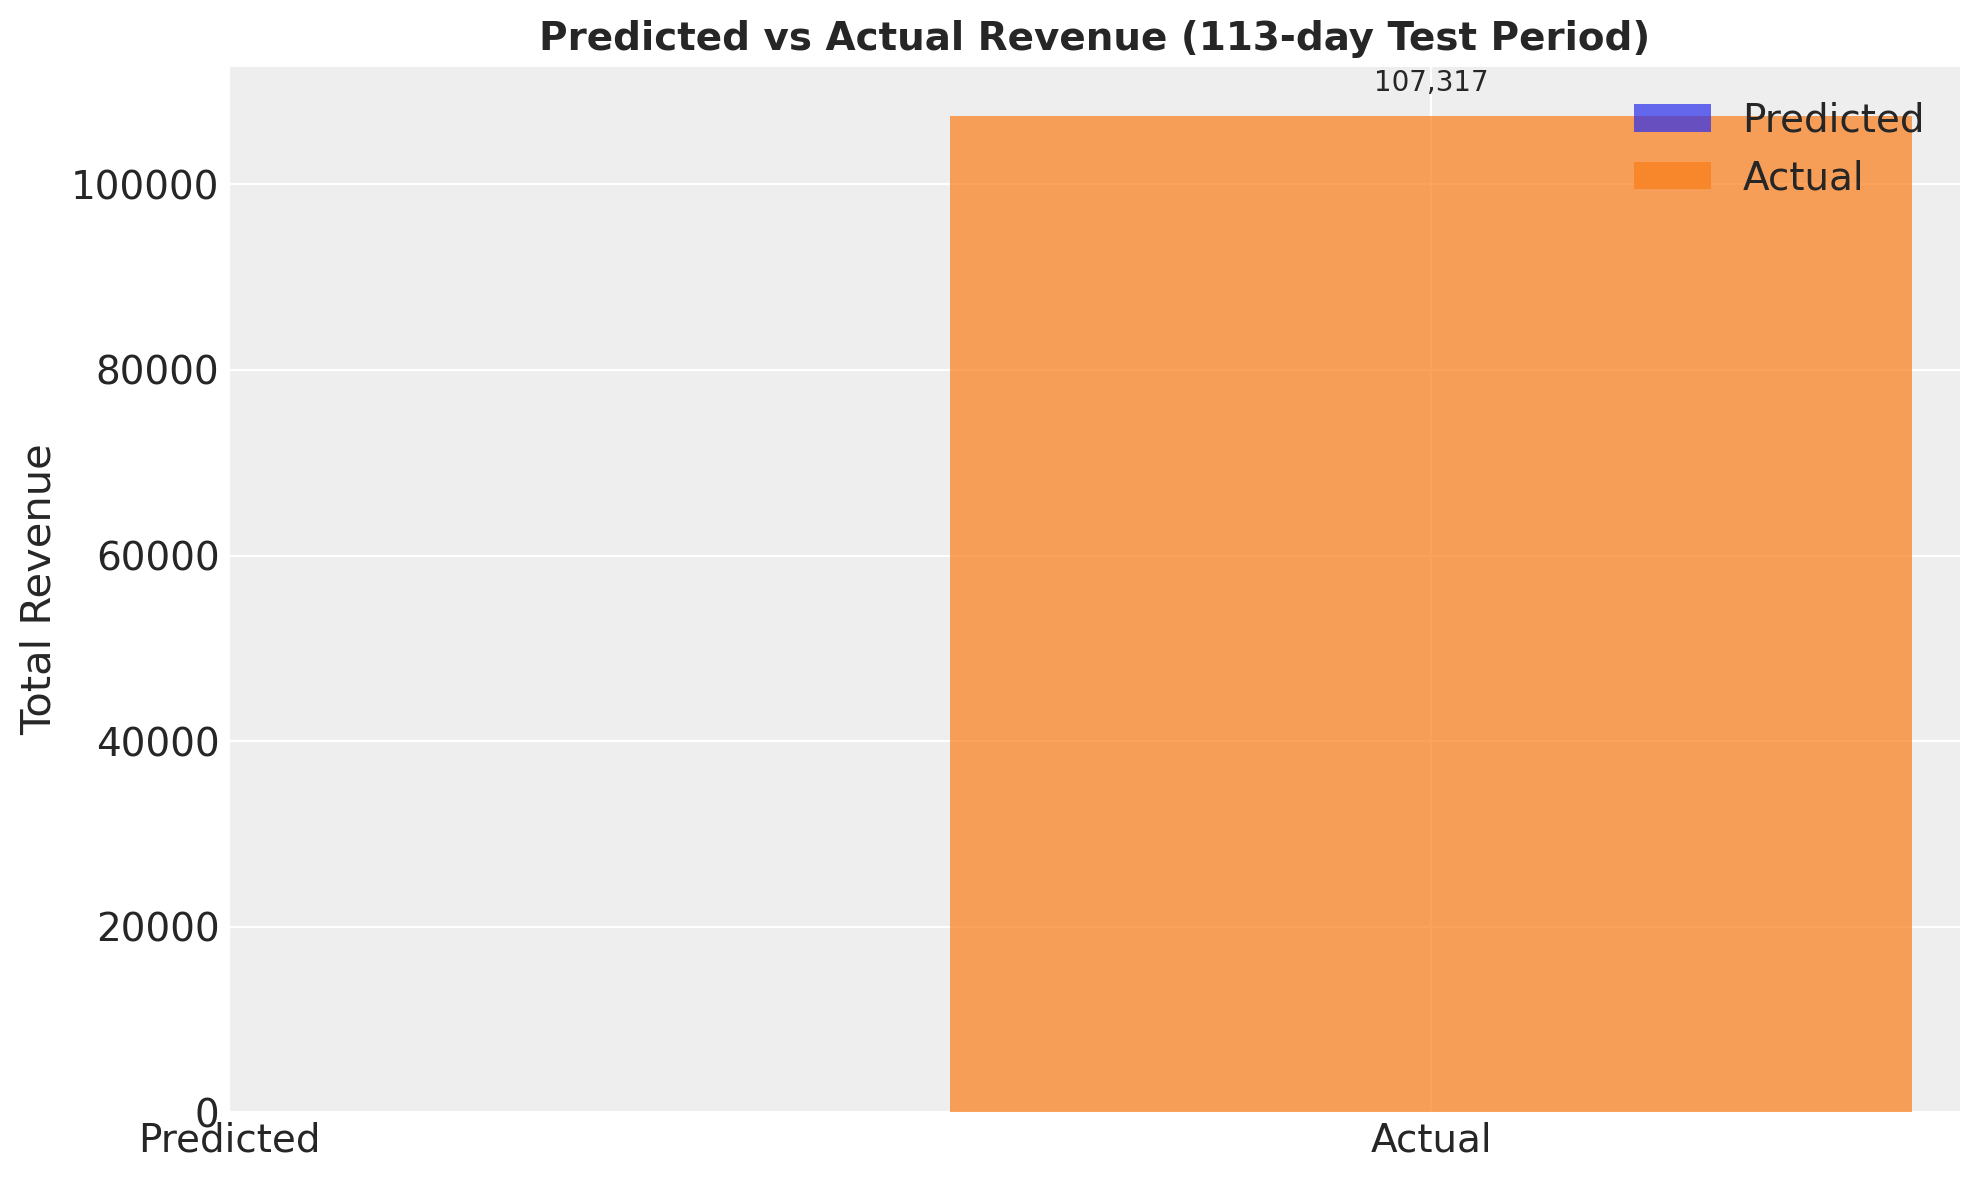

In [ ]:
# Visualization: Predicted vs Actual
if total_clv_mean is not None:
    fig = plot_predicted_vs_actual_revenue(
        predicted_total=total_clv_mean,
        predicted_hdi=total_clv_hdi,
        actual_total=actual_total_revenue,
        title=f"Predicted vs Actual Revenue ({future_t_days}-day Test Period)",
    )
    plt.show()

### Revenue Over Time Plot

This visualization shows the posterior predictive revenue distribution over time,
with:
- **Black line/dots**: Actual revenue
- **Orange bands**: Test period predictions (94% and 50% HDI)
- **Dashed line**: Train/test split

Computing test period predictions...
Computing monthly predictions for 3 periods...
  Computed predictions for 3 periods


/Users/juanitorduz/Documents/website_projects/.pixi/envs/default/lib/python3.13/site-packages/arviz/stats/stats.py:606: RuntimeWarning: invalid value encountered in subtract
  interval_width = np.subtract(ary[interval_idx_inc:], ary[:n_intervals], dtype=np.float64)
/var/folders/cm/3dzy9rdd5s3672z0s1brjkvh0000gn/T/ipykernel_19406/2425589866.py:122: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


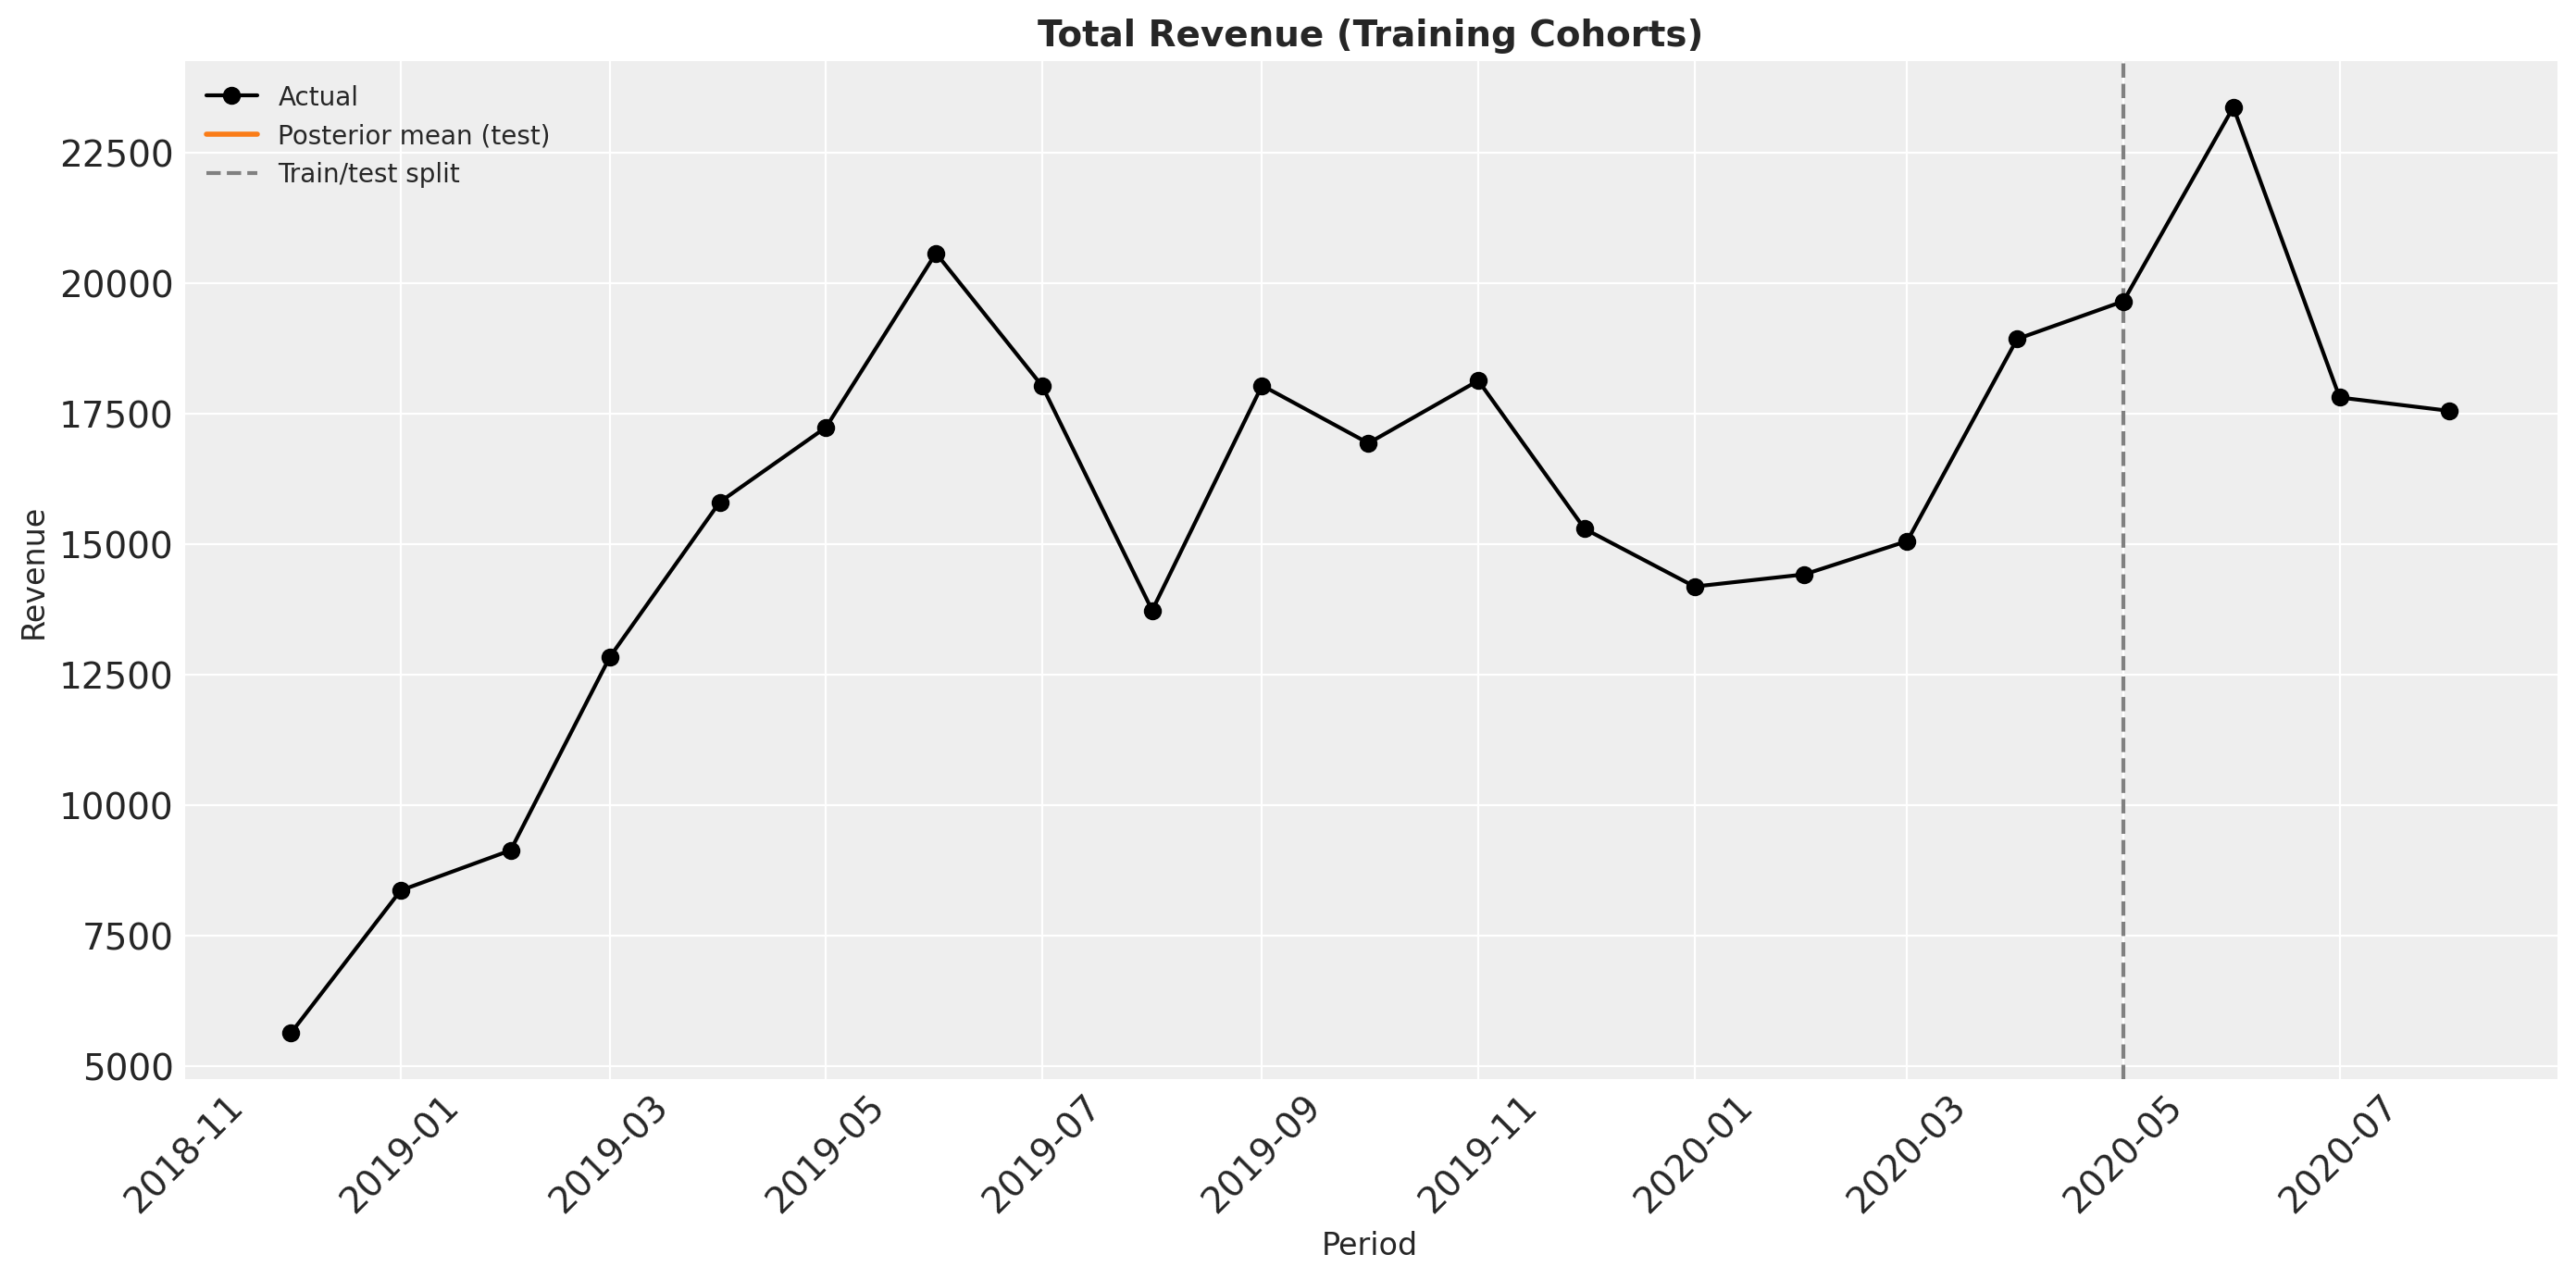

In [ ]:
# Generate the revenue over time plot
# Use DATA_START_DATE for correct cohort assignment (include Oct for cohort computation)
fig = plot_revenue_train_test(
    transactions_df=filtered_df,
    cohort_results=cohort_results,
    train_test_split=PERIOD_TRAIN_TEST_SPLIT,
    test_end=date(2020, 9, 1),  # Use complete months only
    data_start=DATA_START_DATE,  # Include Oct for correct cohort assignment
    hdi_probs=(0.5, 0.94),
    figsize=(14, 7),
    title="Total Revenue (Training Cohorts)",
)
plt.show()

### Out-of-Sample Revenue Predictions by Cohort

Generate faceted plots showing revenue predictions for each cohort.
This visualization is similar to the plots in `hm-transactions.ipynb` but
uses the CLV (BG/NBD + Gamma-Gamma) model predictions instead of BART.

For each cohort we show:
- **Blue line/dots**: Training period observed revenue
- **Orange band**: Test period 94% HDI prediction interval
- **Orange line**: Test period posterior mean prediction
- **Orange dots**: Test period observed revenue
- **Dashed line**: Train/test split

In [ ]:
# Select cohorts to plot (similar to reference notebook)
# Indices: [0, 1, 5, 8, 11, 14, 16, 17] filtered by availability
all_cohorts = sorted(cohort_results.keys())
n_available_cohorts = len(all_cohorts)

# Select cohorts to plot (explicit dates to match hm-transactions.ipynb)
# These are the same cohorts used in the reference notebook for comparison
cohorts_to_plot = [
    date(2018, 11, 1),
    date(2018, 12, 1),
    date(2019, 4, 1),
    date(2019, 7, 1),
    date(2019, 10, 1),
    date(2020, 1, 1),
    date(2020, 3, 1),
    date(2020, 4, 1),
]

print(f"Plotting {len(cohorts_to_plot)} cohorts:")
for c in cohorts_to_plot:
    status = "OK" if c in cohort_results else "no model"
    print(f"  - {c} ({status})")

Plotting 8 cohorts:
  - 2018-11-01 (OK)
  - 2018-12-01 (OK)
  - 2019-04-01 (OK)
  - 2019-07-01 (OK)
  - 2019-10-01 (OK)
  - 2020-01-01 (OK)
  - 2020-03-01 (OK)
  - 2020-04-01 (OK)


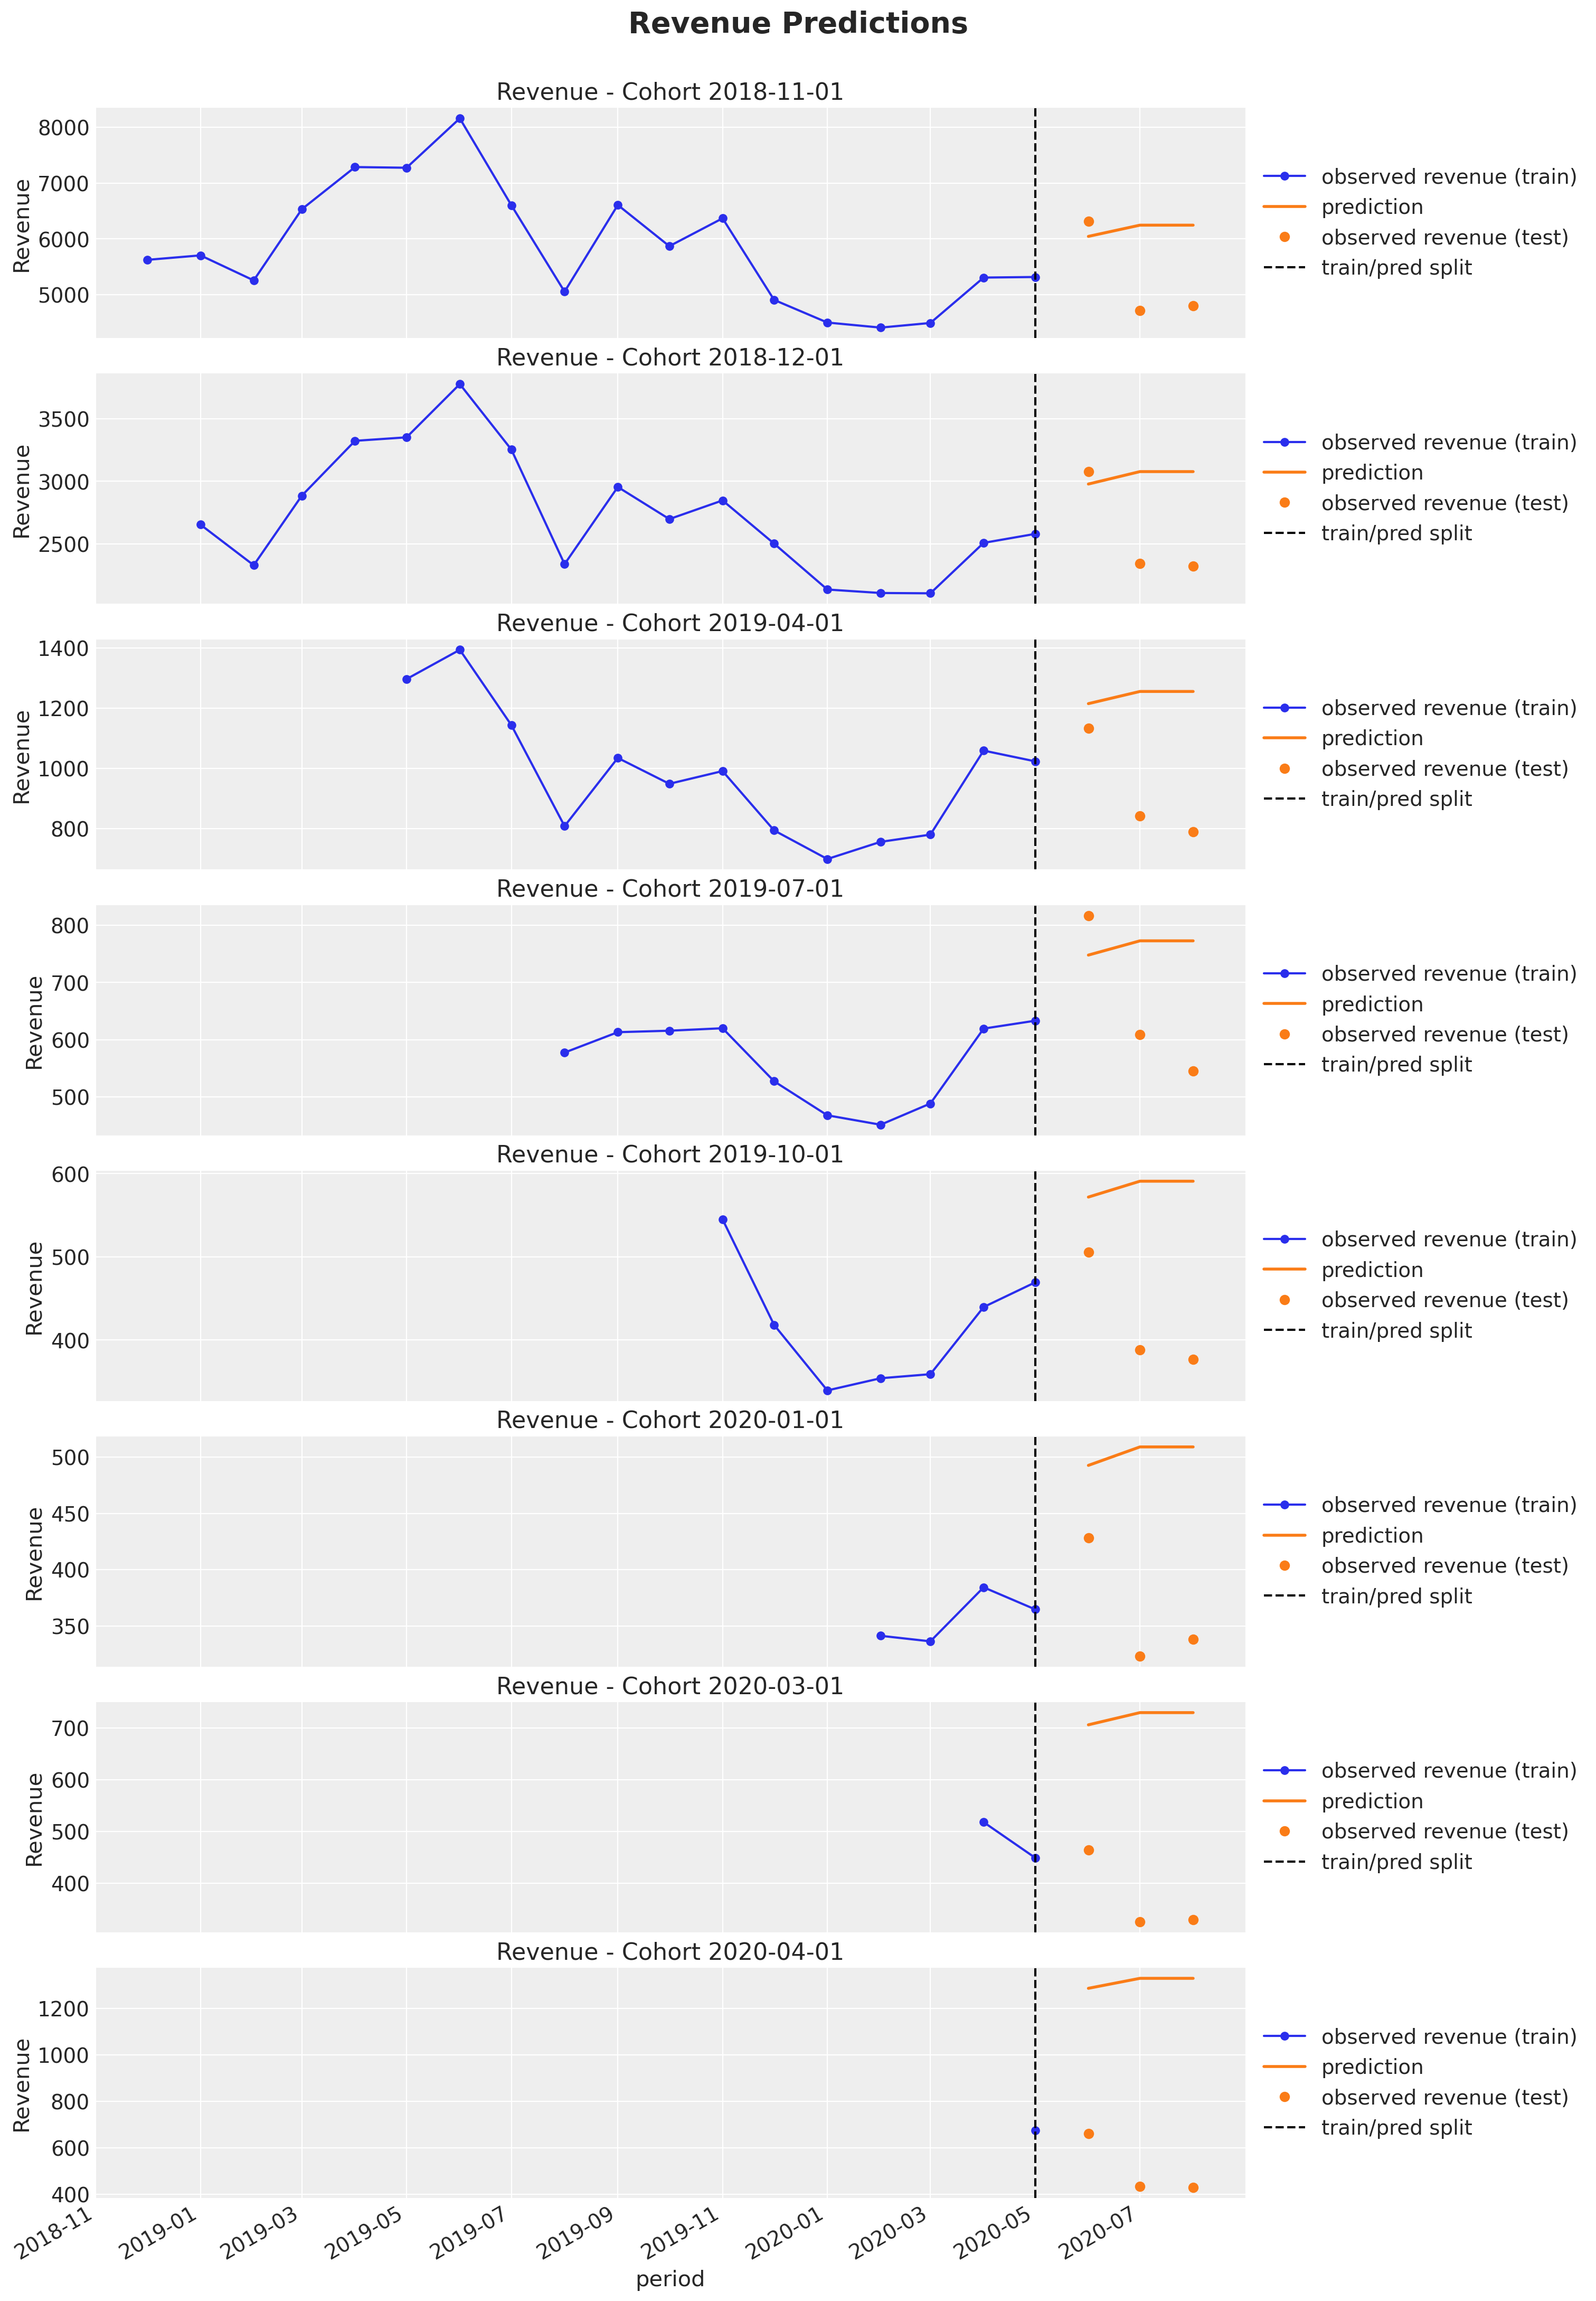

In [ ]:
# Generate the faceted revenue predictions plot
fig = plot_cohort_revenue_predictions(
    cohort_results=cohort_results,
    transactions_df=filtered_df,
    cohorts_to_plot=cohorts_to_plot,
    train_test_split=PERIOD_TRAIN_TEST_SPLIT,
    test_end=date(2020, 9, 1),  # Use complete months only
    data_start=DATA_START_DATE,  # Include Oct for correct cohort assignment
    hdi_prob=0.94,
    figsize=(15, 21),
)
plt.show()

---
## 14. Summary and Conclusions

### Key Findings

1. **Cohort-Based Approach**: By fitting separate models per cohort, we can
   handle the large H&M dataset efficiently.

2. **Subsampling**: Using `MAX_COHORT_SIZE` allows for fast testing and
   debugging. Set to `None` for full dataset analysis.

3. **Model Performance**: Compare the prediction error to evaluate model quality.

### MAP Convergence Fix: Progressive Prior Tightening

#### Problem

MAP estimation for BG/NBD models can fail (producing NaN parameters) for cohorts
with extreme data characteristics:

- **High repeat rates** (e.g., >90%): The optimizer pushes dropout parameters
  toward extreme values, causing numerical instability.
- **Low recency/T ratios** (e.g., <0.25): Customers appear "dormant", leading
  to extreme parameter estimates for the `a` parameter (Beta distribution shape
  for dropout probability).

#### Solution: Progressive Fallback Strategy

We implemented a three-tier prior configuration system:

| Configuration | Prior Sigma | Use Case |
|---------------|-------------|----------|
| **Default** | `sigma=10` | Wide priors for typical cohorts |
| **Tight** | `sigma=2` | High-frequency cohorts (mean freq > 20) |
| **Very Tight** | `sigma=1` | Low recency/T ratio cohorts |

The fitting algorithm:
1. Tries default priors with up to 10 random seeds
2. If all fail, falls back to tight priors (10 more seeds)
3. If still failing, uses very tight priors (10 more seeds)
4. Each attempt validates results for NaN/Inf values early

#### Results

- **2018-11-01** (161K customers, 93.5% repeat rate): Succeeded with tight priors
- **2019-11-01** (37K customers, low recency/T=0.22): Succeeded with very tight priors
- **All 20/20 cohorts** now fit successfully

#### Lessons Learned

1. **Wide priors can cause MAP instability**: For extreme data, unconstrained
   optimization can diverge to NaN. Tighter priors regularize the solution.

2. **Different cohorts need different regularization**: A one-size-fits-all
   prior doesn't work for heterogeneous cohort characteristics.

3. **Random seed variation helps**: Some seeds lead to better local optima.
   Multiple attempts with different seeds increase success probability.

4. **Validate early**: Checking for NaN/Inf after each fit attempt allows
   quick fallback to alternative configurations.

### Limitations

1. **BG/NBD Assumptions**: The model assumes stationary purchase rates, which
   may not hold for seasonal data like fashion retail.

2. **Cohort Independence**: We treat cohorts independently, not accounting for
   potential cross-cohort effects.

3. **Subsampling**: When `MAX_COHORT_SIZE` is set, predictions are for the
   subsampled dataset only. For full population predictions, set to `None`.

4. **Tight Priors Trade-off**: While tight priors stabilize MAP estimation,
   they may bias parameter estimates. Consider MCMC for problematic cohorts
   if unbiased estimates are critical.

### Next Steps

1. Compare with the BART-based cohort model from `hm-transactions.ipynb`
2. Try MCMC fitting for uncertainty quantification
3. Explore cohort-specific seasonality patterns
4. Investigate whether tight-prior cohorts have systematically different
   predictions compared to default-prior cohorts

In [ ]:
# Final summary
print("\n" + "=" * 60)
print("COHORT-BASED CLV MODEL SUMMARY")
print("=" * 60)
print("\nConfiguration:")
print(f"  MAX_COHORT_SIZE: {MAX_COHORT_SIZE}")
print("  Fit Method: MAP")
print("  Time Unit: Days")

print("\nData Summary:")
print(f"  Cohorts from: {COHORT_START_DATE}")
print(f"  Training Period: {DATA_START_DATE} to {PERIOD_TRAIN_TEST_SPLIT}")
print(f"  Test Period: {PERIOD_TRAIN_TEST_SPLIT} to {TEST_PERIOD_END}")
print(f"  Number of Cohorts: {len(cohort_results)}")
print(f"  Total Training Customers: {train_rfm_df.height:,}")

print("\nModel Results:")
total_fit_time = sum(r["fit_time"] for r in cohort_results.values())
print(f"  Total Fitting Time: {total_fit_time:.1f}s ({total_fit_time / 60:.1f} min)")

if total_clv_mean is not None:
    print("\nPrediction Results:")
    print(f"  Forecast Horizon: {future_t_days} days")
    print(f"  Predicted Revenue: {total_clv_mean:,.2f}")
    print(f"  Actual Revenue: {actual_total_revenue:,.2f}")
    print(f"  Prediction Error: {prediction_error_pct:+.1f}%")

print("=" * 60)


COHORT-BASED CLV MODEL SUMMARY

Configuration:
  MAX_COHORT_SIZE: None
  Fit Method: MAP
  Time Unit: Days

Data Summary:
  Cohorts from: 2018-11-01
  Training Period: 2018-10-01 to 2020-06-01
  Test Period: 2020-06-01 to 2020-09-22
  Number of Cohorts: 20
  Total Training Customers: 975,463

Model Results:
  Total Fitting Time: 151.3s (2.5 min)

Prediction Results:
  Forecast Horizon: 113 days
  Predicted Revenue: inf
  Actual Revenue: 107,316.58
  Prediction Error: +inf%
